# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import pandas as pd
import numpy as np
import nltk
from pprint import pprint
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger', 'universal_tagset'])
from sqlalchemy import create_engine
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
from nltk.stem.snowball import SnowballStemmer 
from xgboost import XGBClassifier




%matplotlib inline


[nltk_data] Downloading package punkt to /Users/sabrina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sabrina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sabrina/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/sabrina/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [2]:
# load data from database
engine = create_engine('sqlite:///disaster_response.db')
df = pd.read_sql_table('disaster_response', engine)
X = df['message']  # Message Column
Y = df.iloc[:, 4:] # Classification label
categories = df.columns[4:]
df.shape

(26216, 40)

In [3]:
df.describe()

id       related       request         offer   aid_related  \
count  26216.00000  26216.000000  26216.000000  26216.000000  26216.000000   
mean   15224.82133      0.759307      0.170659      0.004501      0.414251   
std     8826.88914      0.427512      0.376218      0.066940      0.492602   
min        2.00000      0.000000      0.000000      0.000000      0.000000   
25%     7446.75000      1.000000      0.000000      0.000000      0.000000   
50%    15662.50000      1.000000      0.000000      0.000000      0.000000   
75%    22924.25000      1.000000      0.000000      0.000000      1.000000   
max    30265.00000      1.000000      1.000000      1.000000      1.000000   

       medical_help  medical_products  search_and_rescue      security  \
count  26216.000000      26216.000000       26216.000000  26216.000000   
mean       0.079493          0.050084           0.027617      0.017966   
std        0.270513          0.218122           0.163875      0.132831   
min        0.000000          0.000000           0.000000      0.000000   
25%        0.000000          0.000000           0.000000      0.000000   
50%        0.000000          0.000000           0.000000      0.000000   
75%        0.000000          0.000000           0.000000      0.000000   
max        1.000000          1.000000           1.000000      1.000000   

           military  ...   aid_centers  other_infrastructure  weather_related  \
count  26216.000000  ...  26216.000000          26216.000000     26216.000000   
mean       0.032804  ...      0.011787              0.043904         0.278341   
std        0.178128  ...      0.107927              0.204887         0.448191   
min        0.000000  ...      0.000000              0.000000         0.000000   
25%        0.000000  ...      0.000000              0.000000         0.000000   
50%        0.000000  ...      0.000000              0.000000         0.000000   
75%        0.000000  ...      0.000000              0.000000         1.000000   
max        1.000000  ...      1.000000              1.000000         1.000000   

             floods         storm          fire    earthquake          cold  \
count  26216.000000  26216.000000  26216.000000  26216.000000  26216.000000   
mean       0.082202      0.093187      0.010757      0.093645      0.020217   
std        0.274677      0.290700      0.103158      0.291340      0.140743   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       other_weather  direct_report  
count   26216.000000   26216.000000  
mean        0.052487       0.193584  
std         0.223011       0.395114  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.000000       0.000000  
max         1.000000       1.000000  

[8 rows x 37 columns]

### 2. Write a tokenization function to process your text data

In [4]:
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

def tokenize(text):
    text = stemming(text)
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)
    return clean_tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [5]:
# Pipleine 1: Random Forest Classifier

pipeline_rf = Pipeline([('trasform', TfidfVectorizer(tokenizer=tokenize)),
                        ('classifier', MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42)))])


# Pipleine 2: Adaboost Classifier 

pipeline_ada = Pipeline([('trasform', TfidfVectorizer(tokenizer=tokenize)),
                         ('classifier',  MultiOutputClassifier(AdaBoostClassifier(random_state=42)))])


# Pipleine 2: XGBClassifier

pipeline_xgbc = Pipeline([('trasform', TfidfVectorizer(tokenizer=tokenize)),
                         ('classifier',  MultiOutputClassifier(XGBClassifier(random_state=42)))])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)


In [7]:
pipeline_rf.fit(X_train, y_train)
pipeline_ada.fit(X_train, y_train)
pipeline_xgbc.fit(X_train, y_train)


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:37:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

[13:41:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:41:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:41:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:41:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

Pipeline(steps=[('trasform',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x7fd5f9c54a60>)),
                ('classifier',
                 MultiOutputClassifier(estimator=XGBClassifier(base_score=None,
                                                               booster=None,
                                                               colsample_bylevel=None,
                                                               colsample_bynode=None,
                                                               colsample_bytree=None,
                                                               gamma=None,
                                                               gpu_id=None,
                                                               importance_type='gain',
                                                               interaction_constraints=None,
                                                               learning_rate=None,
                          

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [8]:
y_pred_rf = pipeline_rf.predict(X_test)
y_pred_ada = pipeline_ada.predict(X_test)
y_pred_xgbc = pipeline_xgbc.predict(X_test)


In [9]:
def test_pipeline(y_pred, y_test, categories):
    f1_list = []
    recall_list = []
    for i, col in enumerate(categories):
        print('***** Category: {} ***** '.format(categories[i]))
        print("***** Testing data *****")

        f1 = f1_score(y_test[col], y_pred[:, i])
        recall = recall_score(y_test[col], y_pred[:, i])
        
        
        f1_list.append(f1)
        recall_list.append(recall)
        
        
        print('F1 Score {}\n\n'.format(f1))
        conf_mat = confusion_matrix(y_test[col], y_pred[:, i])
        if conf_mat.shape[0] > 1 and conf_mat.shape[1] > 1:
            df_cm = pd.DataFrame(conf_mat, range(2), range(2))
            sn.set(font_scale=1.4) # for label size
            sn.heatmap(df_cm, annot=True, cmap = 'Blues', fmt = 'g', annot_kws={"size": 16}) # font size
            plt.ylabel('Actual')
            plt.xlabel('Predicted')

            plt.show()
            i = i + 1
        
    return f1_list, recall_list


***** Category: related ***** 
***** Testing data *****
F1 Score 0.8768718801996673




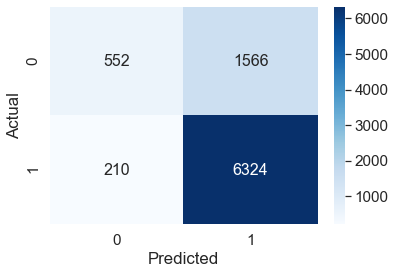

***** Category: request ***** 
***** Testing data *****
F1 Score 0.5572232645403377




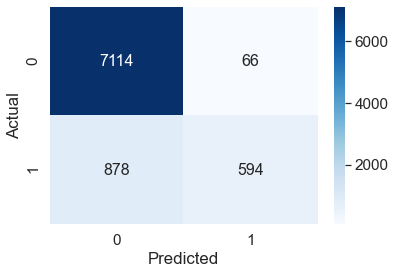

***** Category: offer ***** 
***** Testing data *****
F1 Score 0.0




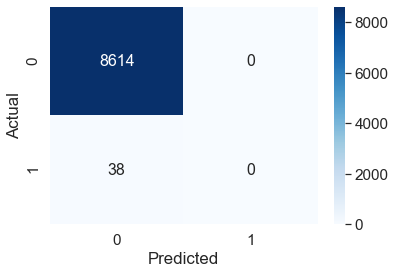

***** Category: aid_related ***** 
***** Testing data *****
F1 Score 0.6806762521725391




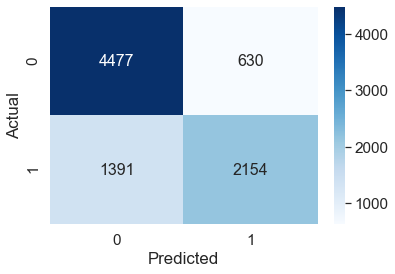

***** Category: medical_help ***** 
***** Testing data *****
F1 Score 0.06802721088435375




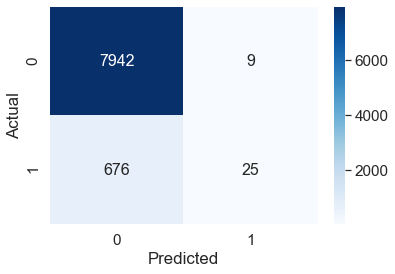

***** Category: medical_products ***** 
***** Testing data *****
F1 Score 0.10855949895615867




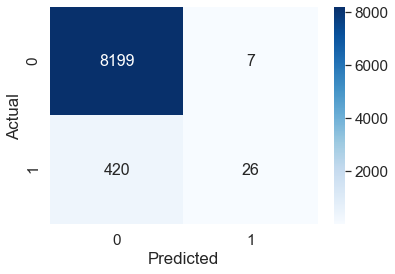

***** Category: search_and_rescue ***** 
***** Testing data *****
F1 Score 0.058577405857740586




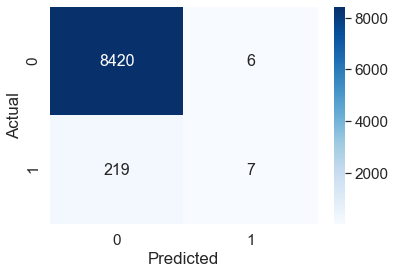

***** Category: security ***** 
***** Testing data *****
F1 Score 0.0




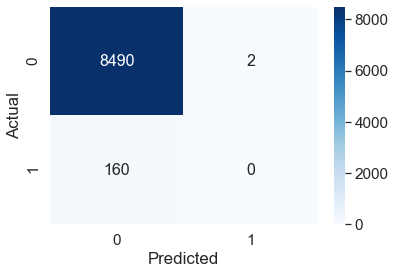

***** Category: military ***** 
***** Testing data *****
F1 Score 0.056737588652482275




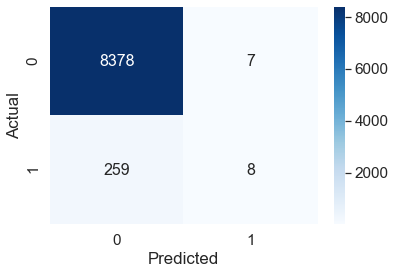

***** Category: child_alone ***** 
***** Testing data *****
F1 Score 0.0


***** Category: water ***** 
***** Testing data *****
F1 Score 0.4251748251748252




/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


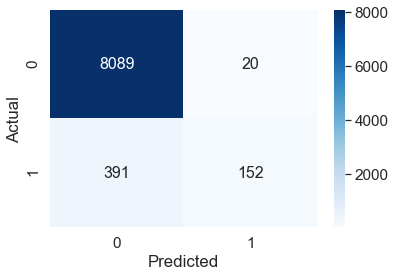

***** Category: food ***** 
***** Testing data *****
F1 Score 0.5154639175257731




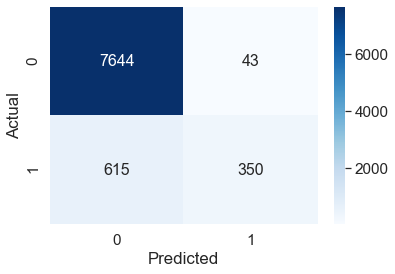

***** Category: shelter ***** 
***** Testing data *****
F1 Score 0.41480038948393383




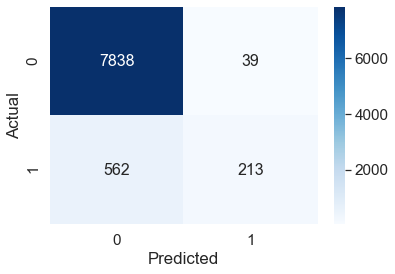

***** Category: clothing ***** 
***** Testing data *****
F1 Score 0.08888888888888888




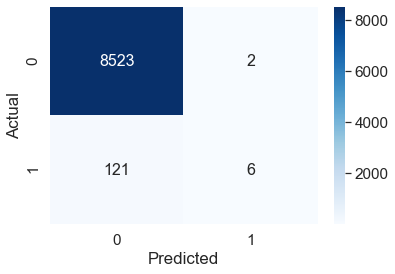

***** Category: money ***** 
***** Testing data *****
F1 Score 0.0606060606060606




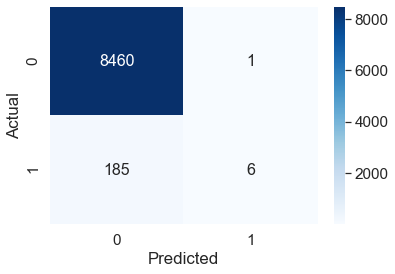

***** Category: missing_people ***** 
***** Testing data *****
F1 Score 0.0




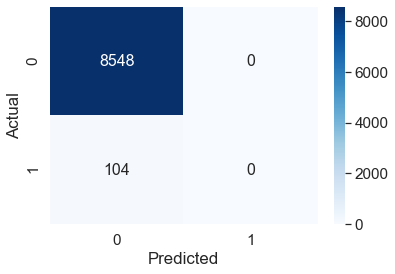

***** Category: refugees ***** 
***** Testing data *****
F1 Score 0.033444816053511704




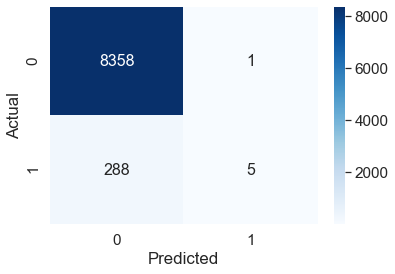

***** Category: death ***** 
***** Testing data *****
F1 Score 0.12844036697247707




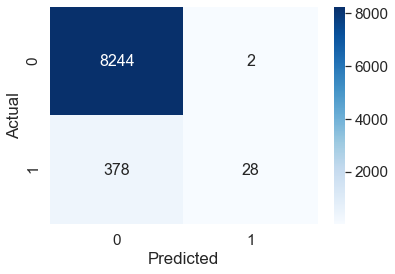

***** Category: other_aid ***** 
***** Testing data *****
F1 Score 0.02583979328165375




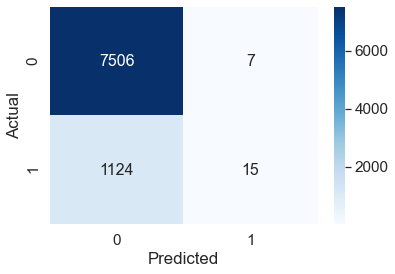

***** Category: infrastructure_related ***** 
***** Testing data *****
F1 Score 0.0




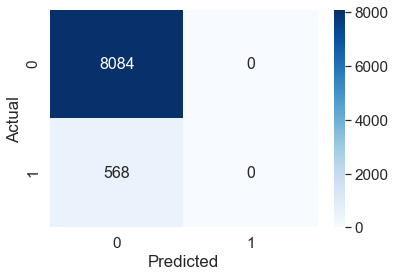

***** Category: transport ***** 
***** Testing data *****
F1 Score 0.11764705882352941




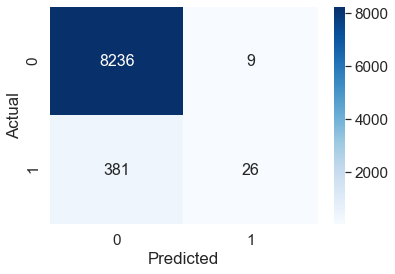

***** Category: buildings ***** 
***** Testing data *****
F1 Score 0.06521739130434782




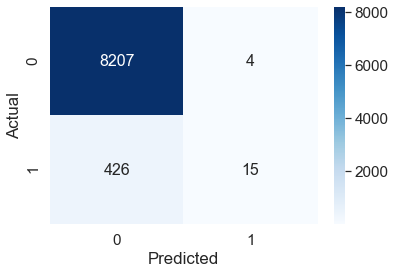

***** Category: electricity ***** 
***** Testing data *****
F1 Score 0.04232804232804233




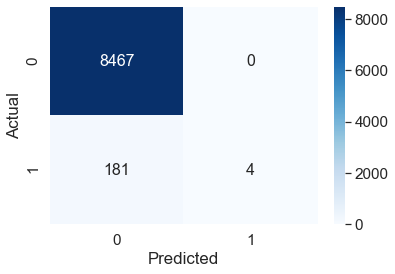

***** Category: tools ***** 
***** Testing data *****
F1 Score 0.0




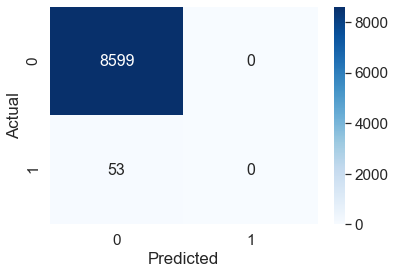

***** Category: hospitals ***** 
***** Testing data *****
F1 Score 0.0




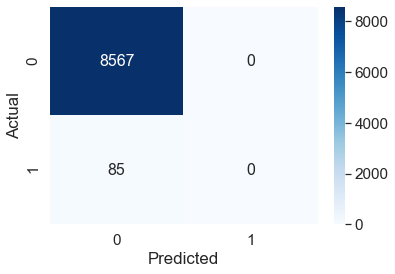

***** Category: shops ***** 
***** Testing data *****
F1 Score 0.0




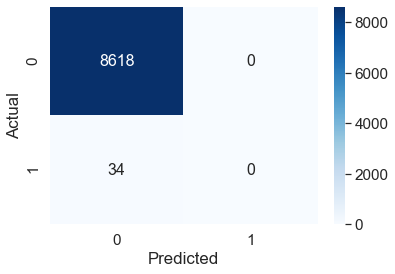

***** Category: aid_centers ***** 
***** Testing data *****
F1 Score 0.0




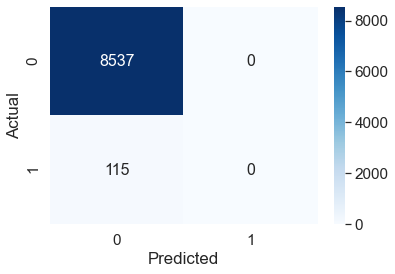

***** Category: other_infrastructure ***** 
***** Testing data *****
F1 Score 0.0




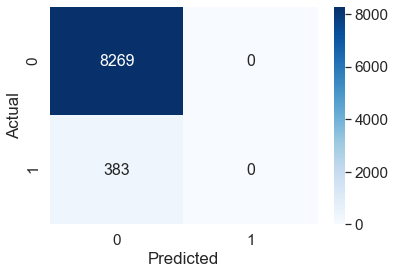

***** Category: weather_related ***** 
***** Testing data *****
F1 Score 0.7081999507510466




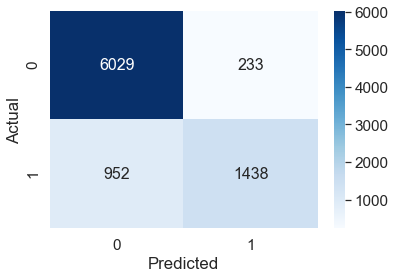

***** Category: floods ***** 
***** Testing data *****
F1 Score 0.5423387096774193




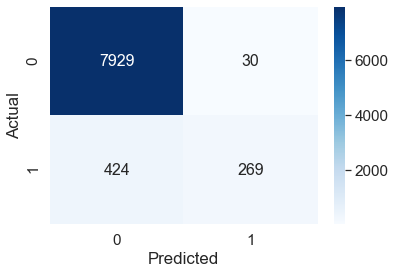

***** Category: storm ***** 
***** Testing data *****
F1 Score 0.5503568596352102




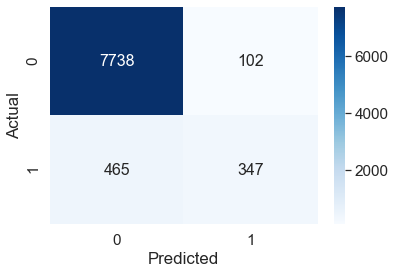

***** Category: fire ***** 
***** Testing data *****
F1 Score 0.0




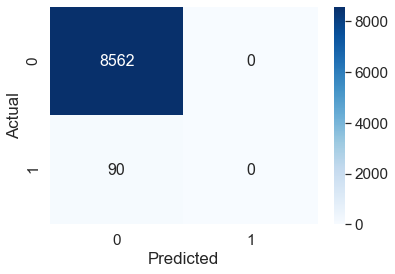

***** Category: earthquake ***** 
***** Testing data *****
F1 Score 0.8083044982698964




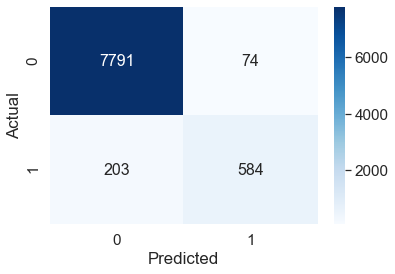

***** Category: cold ***** 
***** Testing data *****
F1 Score 0.10999999999999999




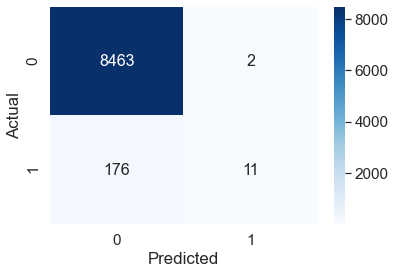

***** Category: other_weather ***** 
***** Testing data *****
F1 Score 0.008791208791208791




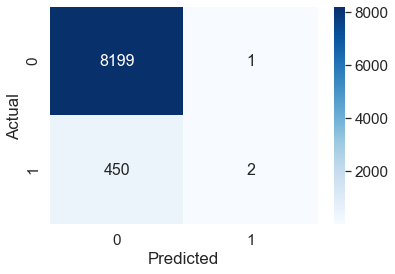

***** Category: direct_report ***** 
***** Testing data *****
F1 Score 0.48428207306711984




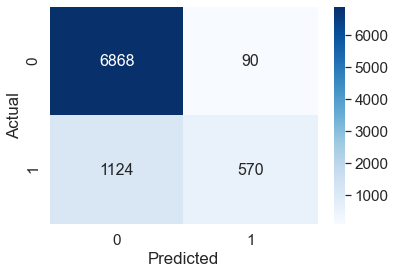

***** Category: related ***** 
***** Testing data *****
F1 Score 0.8719937936384795




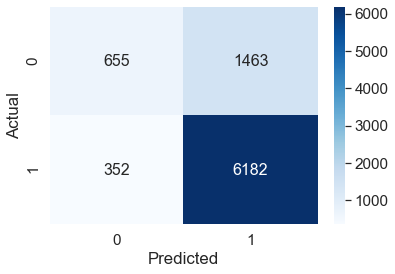

***** Category: request ***** 
***** Testing data *****
F1 Score 0.649802371541502




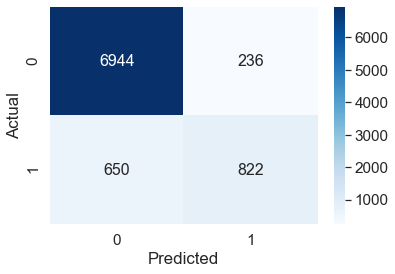

***** Category: offer ***** 
***** Testing data *****
F1 Score 0.04081632653061224




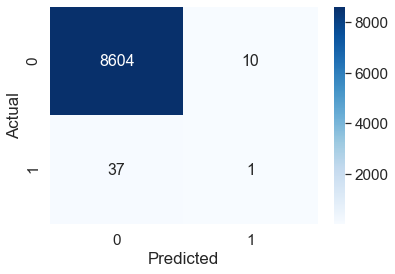

***** Category: aid_related ***** 
***** Testing data *****
F1 Score 0.6591478696741855




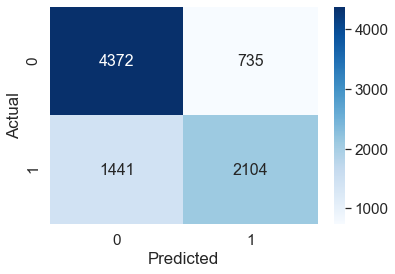

***** Category: medical_help ***** 
***** Testing data *****
F1 Score 0.3827751196172248




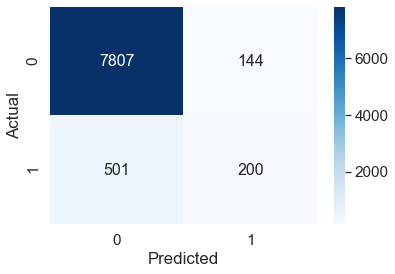

***** Category: medical_products ***** 
***** Testing data *****
F1 Score 0.380517503805175




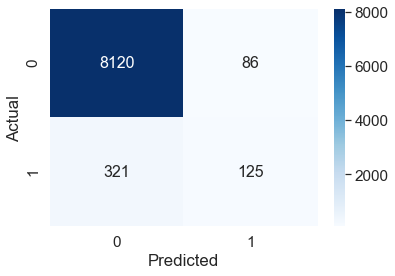

***** Category: search_and_rescue ***** 
***** Testing data *****
F1 Score 0.23287671232876714




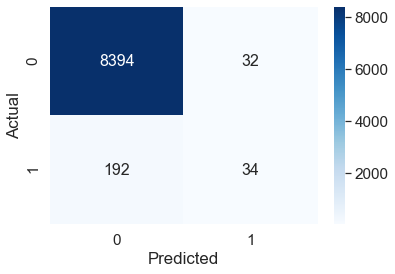

***** Category: security ***** 
***** Testing data *****
F1 Score 0.0546448087431694




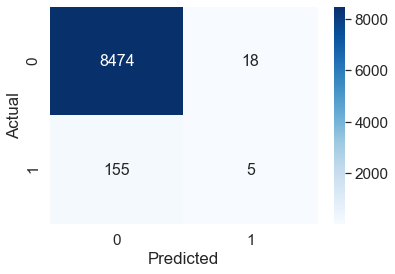

***** Category: military ***** 
***** Testing data *****
F1 Score 0.3690773067331671




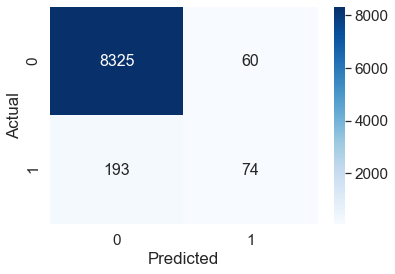

***** Category: child_alone ***** 
***** Testing data *****
F1 Score 0.0


***** Category: water ***** 
***** Testing data *****
F1 Score 0.6692759295499021




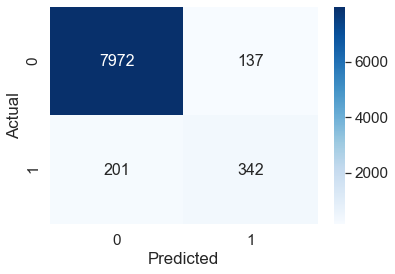

***** Category: food ***** 
***** Testing data *****
F1 Score 0.7352941176470589




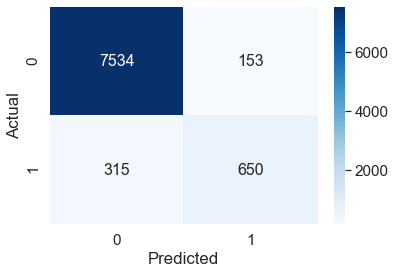

***** Category: shelter ***** 
***** Testing data *****
F1 Score 0.6553505535055351




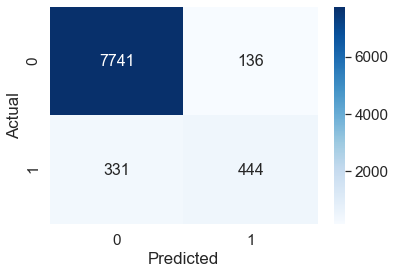

***** Category: clothing ***** 
***** Testing data *****
F1 Score 0.522167487684729




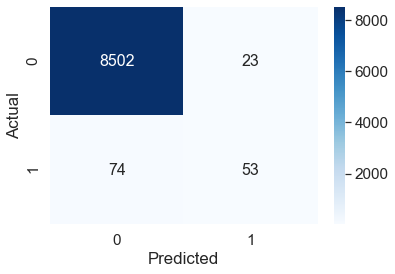

***** Category: money ***** 
***** Testing data *****
F1 Score 0.37873754152823924




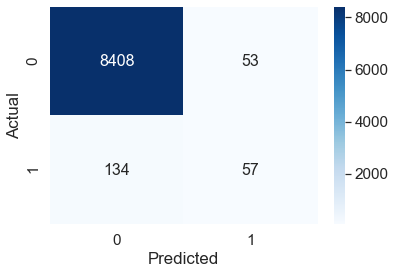

***** Category: missing_people ***** 
***** Testing data *****
F1 Score 0.20967741935483872




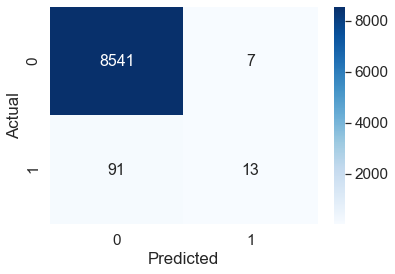

***** Category: refugees ***** 
***** Testing data *****
F1 Score 0.3494252873563218




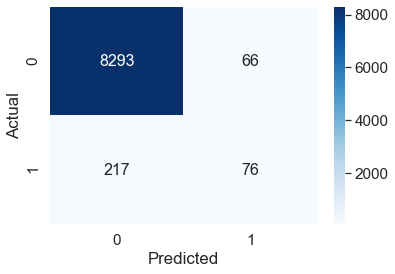

***** Category: death ***** 
***** Testing data *****
F1 Score 0.5




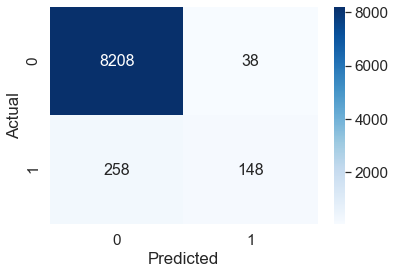

***** Category: other_aid ***** 
***** Testing data *****
F1 Score 0.24681421864520453




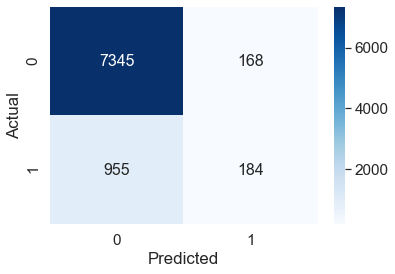

***** Category: infrastructure_related ***** 
***** Testing data *****
F1 Score 0.14327485380116958




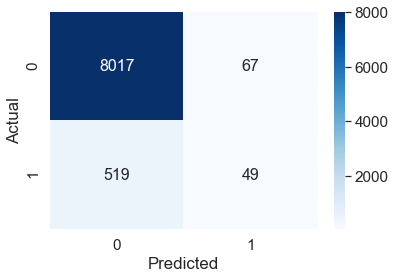

***** Category: transport ***** 
***** Testing data *****
F1 Score 0.2923076923076923




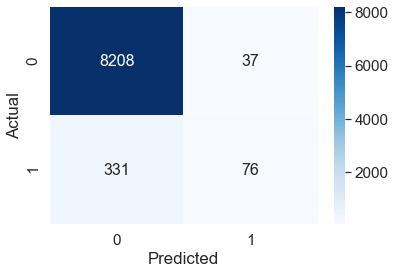

***** Category: buildings ***** 
***** Testing data *****
F1 Score 0.5028735632183908




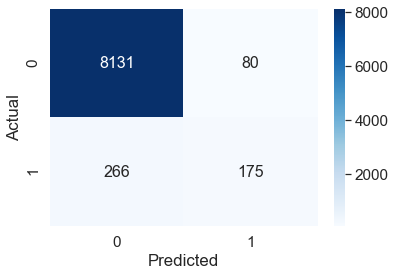

***** Category: electricity ***** 
***** Testing data *****
F1 Score 0.28125




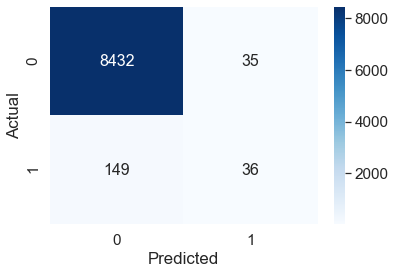

***** Category: tools ***** 
***** Testing data *****
F1 Score 0.0




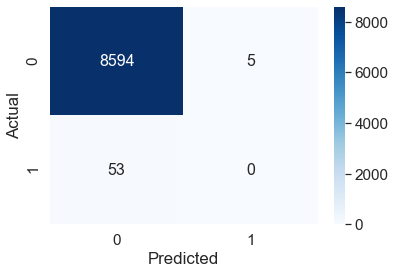

***** Category: hospitals ***** 
***** Testing data *****
F1 Score 0.18803418803418806




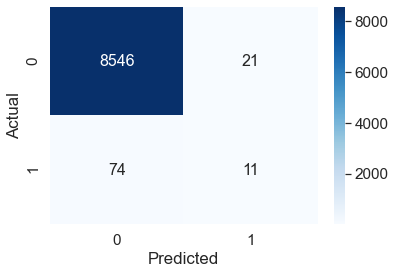

***** Category: shops ***** 
***** Testing data *****
F1 Score 0.0




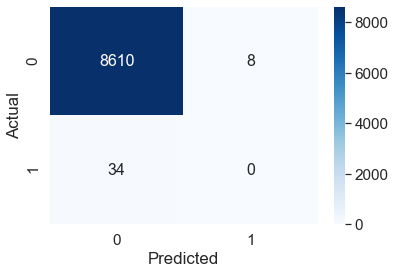

***** Category: aid_centers ***** 
***** Testing data *****
F1 Score 0.08333333333333333




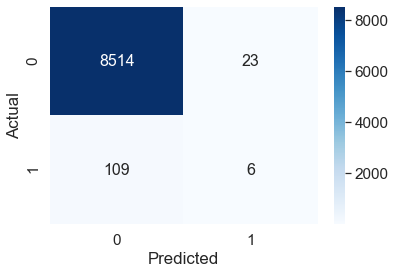

***** Category: other_infrastructure ***** 
***** Testing data *****
F1 Score 0.11111111111111112




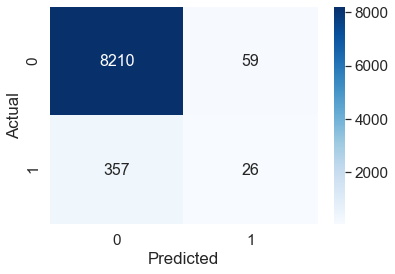

***** Category: weather_related ***** 
***** Testing data *****
F1 Score 0.7310704960835509




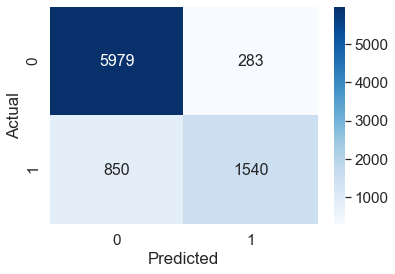

***** Category: floods ***** 
***** Testing data *****
F1 Score 0.6695652173913045




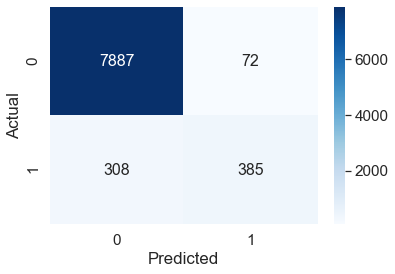

***** Category: storm ***** 
***** Testing data *****
F1 Score 0.6116983791402395




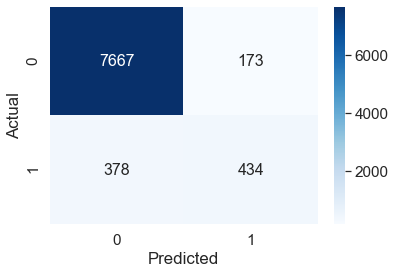

***** Category: fire ***** 
***** Testing data *****
F1 Score 0.37209302325581395




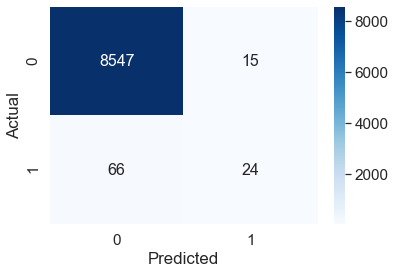

***** Category: earthquake ***** 
***** Testing data *****
F1 Score 0.809556313993174




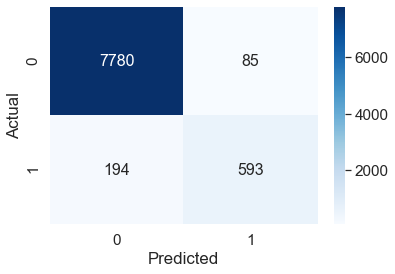

***** Category: cold ***** 
***** Testing data *****
F1 Score 0.4680851063829788




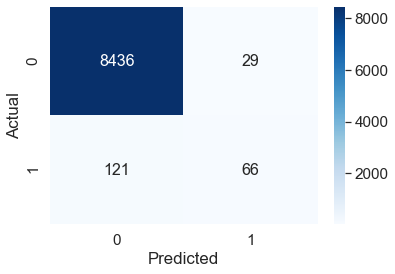

***** Category: other_weather ***** 
***** Testing data *****
F1 Score 0.2430213464696223




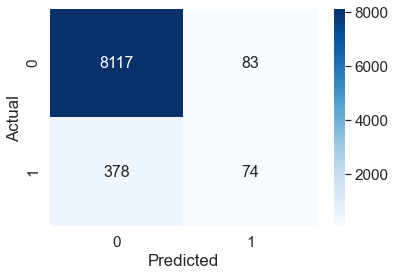

***** Category: direct_report ***** 
***** Testing data *****
F1 Score 0.5674715909090908




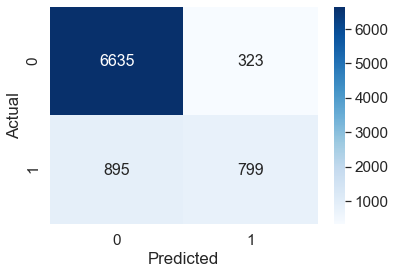

***** Category: related ***** 
***** Testing data *****
F1 Score 0.8832862421212778




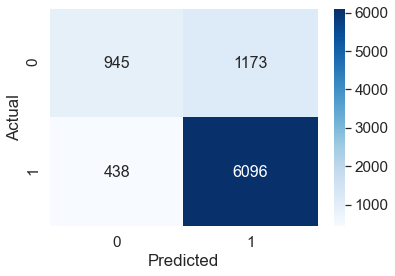

***** Category: request ***** 
***** Testing data *****
F1 Score 0.6650924832743014




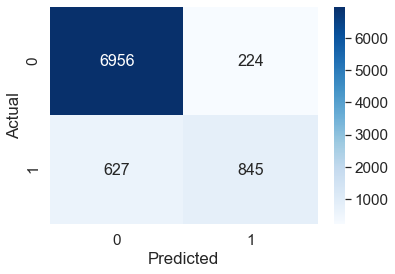

***** Category: offer ***** 
***** Testing data *****
F1 Score 0.0




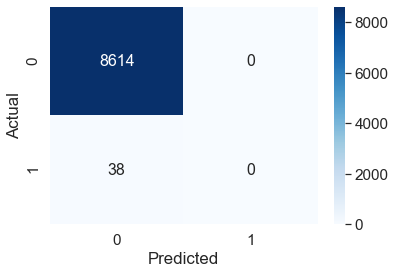

***** Category: aid_related ***** 
***** Testing data *****
F1 Score 0.698118932038835




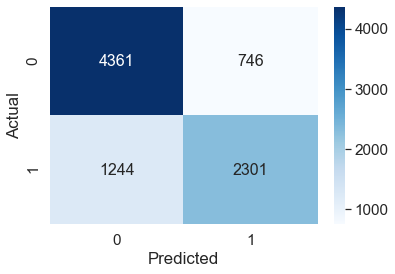

***** Category: medical_help ***** 
***** Testing data *****
F1 Score 0.3876567020250723




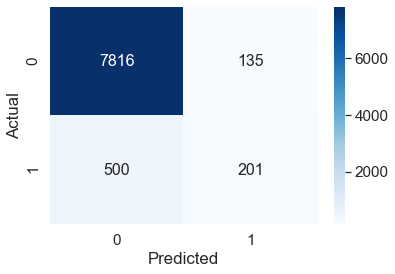

***** Category: medical_products ***** 
***** Testing data *****
F1 Score 0.3981042654028436




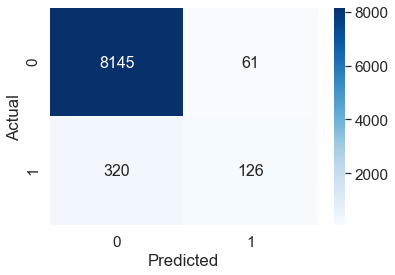

***** Category: search_and_rescue ***** 
***** Testing data *****
F1 Score 0.20289855072463767




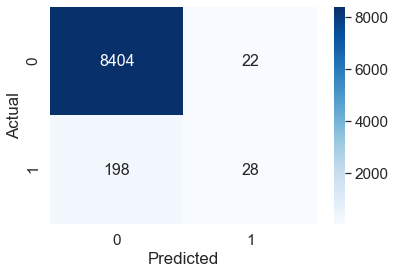

***** Category: security ***** 
***** Testing data *****
F1 Score 0.012048192771084338




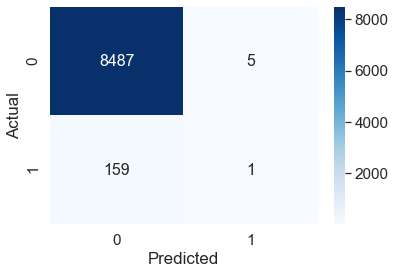

***** Category: military ***** 
***** Testing data *****
F1 Score 0.3877551020408163




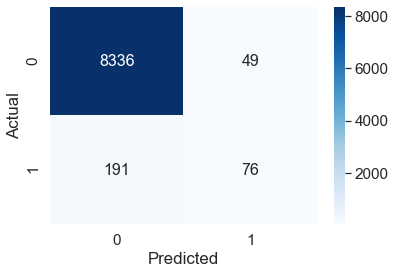

***** Category: child_alone ***** 
***** Testing data *****
F1 Score 0.0


***** Category: water ***** 
***** Testing data *****
F1 Score 0.7096774193548386




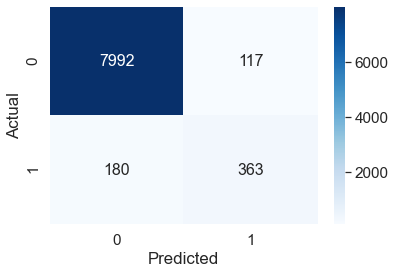

***** Category: food ***** 
***** Testing data *****
F1 Score 0.7780172413793103




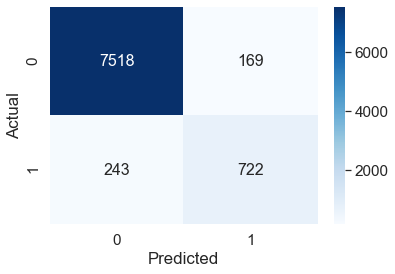

***** Category: shelter ***** 
***** Testing data *****
F1 Score 0.6724262059035276




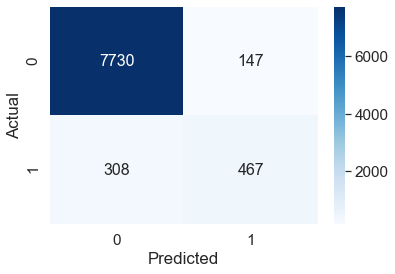

***** Category: clothing ***** 
***** Testing data *****
F1 Score 0.45989304812834225




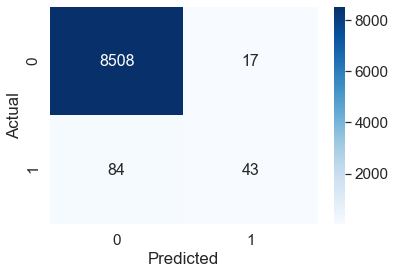

***** Category: money ***** 
***** Testing data *****
F1 Score 0.3796610169491525




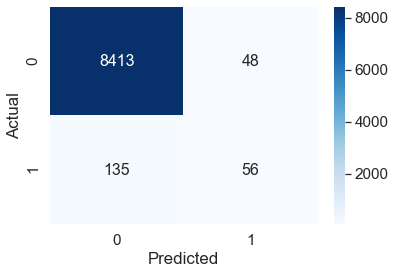

***** Category: missing_people ***** 
***** Testing data *****
F1 Score 0.12389380530973451




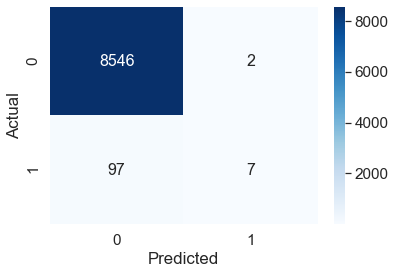

***** Category: refugees ***** 
***** Testing data *****
F1 Score 0.34928229665071764




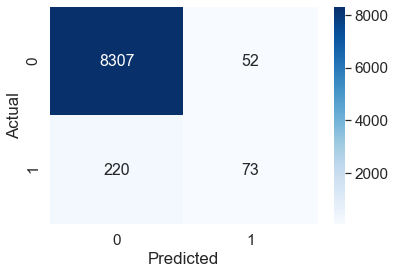

***** Category: death ***** 
***** Testing data *****
F1 Score 0.5674418604651162




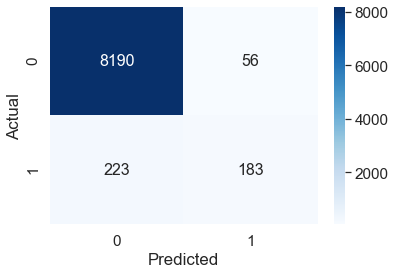

***** Category: other_aid ***** 
***** Testing data *****
F1 Score 0.261455525606469




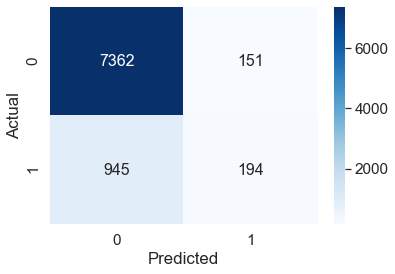

***** Category: infrastructure_related ***** 
***** Testing data *****
F1 Score 0.11229135053110775




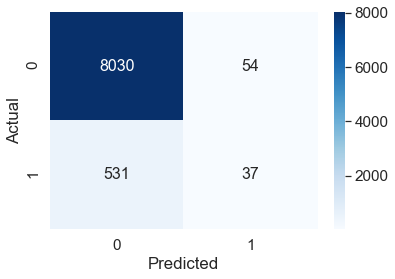

***** Category: transport ***** 
***** Testing data *****
F1 Score 0.3570127504553734




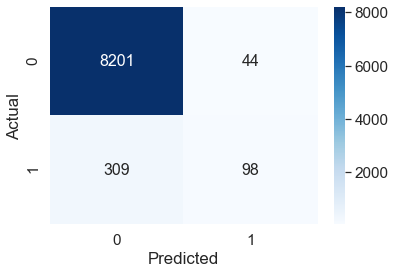

***** Category: buildings ***** 
***** Testing data *****
F1 Score 0.47515527950310554




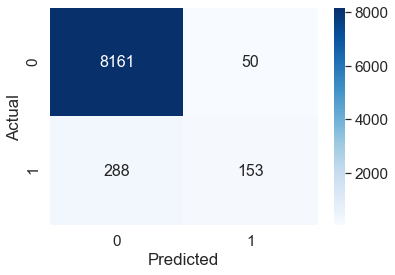

***** Category: electricity ***** 
***** Testing data *****
F1 Score 0.3650190114068441




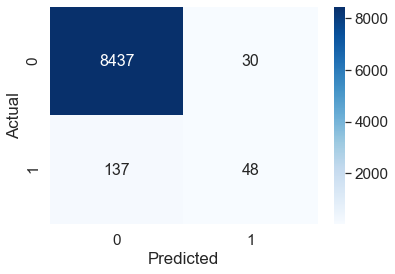

***** Category: tools ***** 
***** Testing data *****
F1 Score 0.0




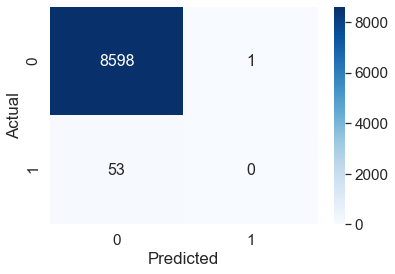

***** Category: hospitals ***** 
***** Testing data *****
F1 Score 0.04301075268817204




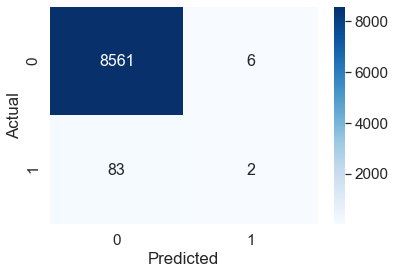

***** Category: shops ***** 
***** Testing data *****
F1 Score 0.0




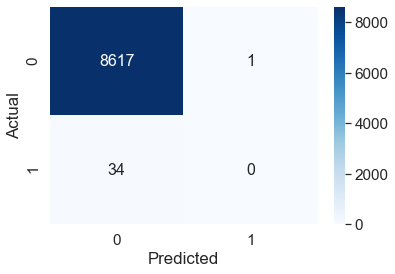

***** Category: aid_centers ***** 
***** Testing data *****
F1 Score 0.07936507936507936




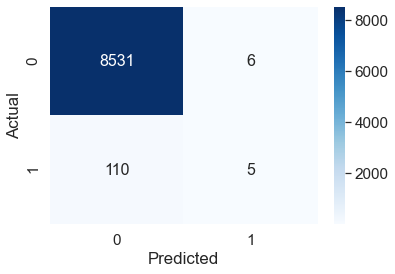

***** Category: other_infrastructure ***** 
***** Testing data *****
F1 Score 0.05581395348837209




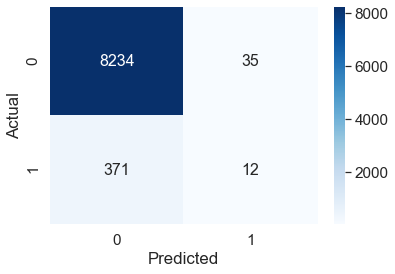

***** Category: weather_related ***** 
***** Testing data *****
F1 Score 0.7584931823434249




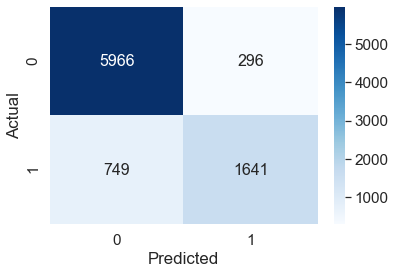

***** Category: floods ***** 
***** Testing data *****
F1 Score 0.6787564766839378




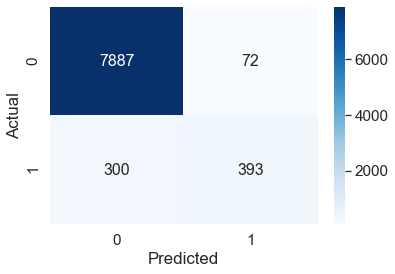

***** Category: storm ***** 
***** Testing data *****
F1 Score 0.6802363755745241




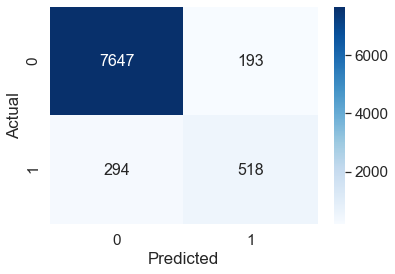

***** Category: fire ***** 
***** Testing data *****
F1 Score 0.31578947368421056




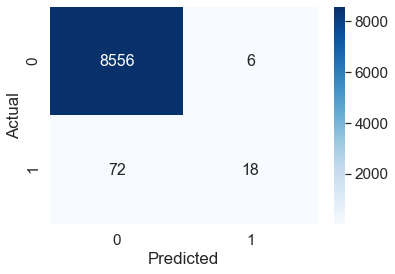

***** Category: earthquake ***** 
***** Testing data *****
F1 Score 0.8309953239812959




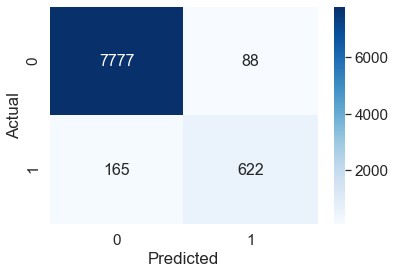

***** Category: cold ***** 
***** Testing data *****
F1 Score 0.5136986301369864




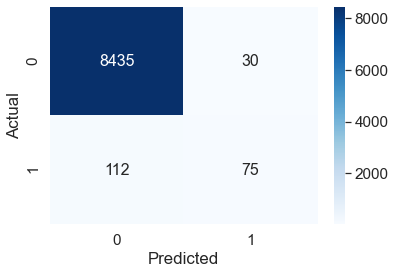

***** Category: other_weather ***** 
***** Testing data *****
F1 Score 0.17406749555950268




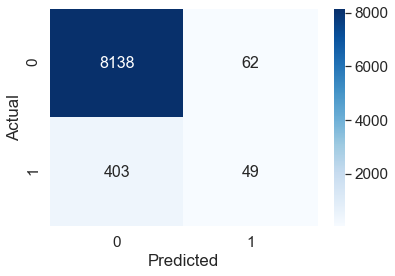

***** Category: direct_report ***** 
***** Testing data *****
F1 Score 0.5878571428571429




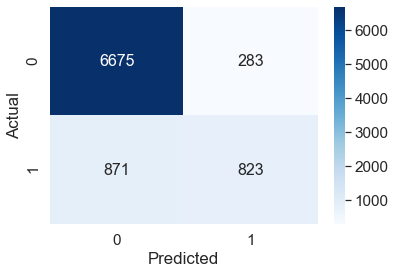

In [10]:
f1_list_rf, recall_list_rf = test_pipeline(y_pred_rf, y_test, categories)
f1_list_ada, recall_list_ada = test_pipeline(y_pred_ada, y_test, categories)
f1_list_xgbc, recall_list_xgbc = test_pipeline(y_pred_xgbc, y_test, categories)


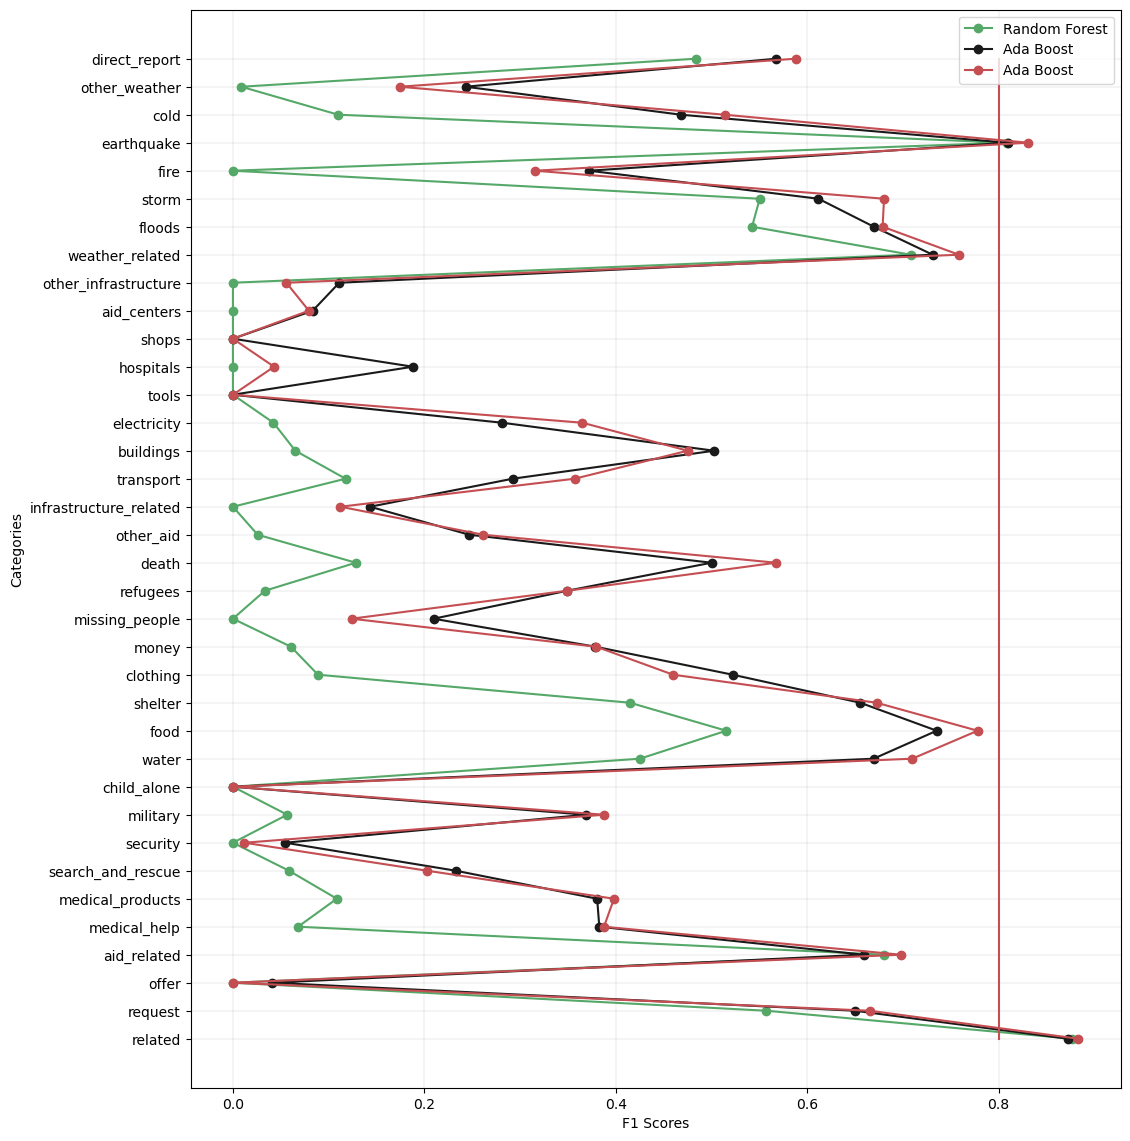

In [11]:
plt.rcParams.update(plt.rcParamsDefault)

plt.figure(figsize=(12, 14)) 


plt.plot(f1_list_rf, categories, 'o-g', label = 'Random Forest')
plt.plot(f1_list_ada, categories, 'o-k', label = 'Ada Boost')
plt.plot(f1_list_xgbc, categories, 'o-r', label = 'XGBC Boost')

plt.plot([0.8] * len(categories), categories, '-r')
plt.xlabel('F1 Scores')
plt.ylabel('Categories')
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.legend(loc="upper right")

plt.show()


### 6. Improve your model
Use grid search to find better parameters. 

In [12]:

param_grid = {
              "classifier__estimator__n_estimators": [100, 300, 500, 1000]
             }



pipeline_ada = Pipeline([('trasform', TfidfVectorizer(tokenizer=tokenize)),
                         ('classifier',  MultiOutputClassifier(AdaBoostClassifier(random_state=42)))])
# Random search of parameters, using 10 fold cross validation, 
# search across 100 different combinations, and use all available cores
ada_grid_search = GridSearchCV(estimator = pipeline_ada, param_grid = param_grid, 
                               cv = 5, verbose = 2)

In [13]:
ada_grid_search.fit(X_train, y_train)



Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] classifier__estimator__n_estimators=100 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... classifier__estimator__n_estimators=100, total= 2.3min
[CV] classifier__estimator__n_estimators=100 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.3min remaining:    0.0s


[CV] .......... classifier__estimator__n_estimators=100, total= 2.4min
[CV] classifier__estimator__n_estimators=100 .........................
[CV] .......... classifier__estimator__n_estimators=100, total= 2.3min
[CV] classifier__estimator__n_estimators=100 .........................
[CV] .......... classifier__estimator__n_estimators=100, total= 2.3min
[CV] classifier__estimator__n_estimators=100 .........................
[CV] .......... classifier__estimator__n_estimators=100, total= 2.3min
[CV] classifier__estimator__n_estimators=300 .........................
[CV] .......... classifier__estimator__n_estimators=300, total= 6.9min
[CV] classifier__estimator__n_estimators=300 .........................
[CV] .......... classifier__estimator__n_estimators=300, total= 6.6min
[CV] classifier__estimator__n_estimators=300 .........................
[CV] .......... classifier__estimator__n_estimators=300, total= 6.7min
[CV] classifier__estimator__n_estimators=300 .........................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 208.3min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('trasform',
                                        TfidfVectorizer(tokenizer=<function tokenize at 0x7fd5f9c54a60>)),
                                       ('classifier',
                                        MultiOutputClassifier(estimator=AdaBoostClassifier(random_state=42)))]),
             param_grid={'classifier__estimator__n_estimators': [100, 300, 500,
                                                                 1000]},
             verbose=2)

In [14]:
ada_grid_search.best_estimator_

Pipeline(steps=[('trasform',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x7fd5f9c54a60>)),
                ('classifier',
                 MultiOutputClassifier(estimator=AdaBoostClassifier(n_estimators=100,
                                                                    random_state=42)))])

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [15]:
pipeline_ada = Pipeline([  ('trasform', TfidfVectorizer(tokenizer=tokenize)),
                            ('classifier',
                     MultiOutputClassifier(estimator=AdaBoostClassifier(n_estimators=1000,
                                                                    random_state=42)))])

In [16]:
pipeline_ada.fit(X_train, y_train)

Pipeline(steps=[('trasform',
                 TfidfVectorizer(tokenizer=<function tokenize at 0x7fd5f9c54a60>)),
                ('classifier',
                 MultiOutputClassifier(estimator=AdaBoostClassifier(n_estimators=1000,
                                                                    random_state=42)))])

In [17]:
y_pred = pipeline_ada.predict(X_test)

***** Category: related ***** 
***** Testing data *****
F1 Score 0.8713717842946073




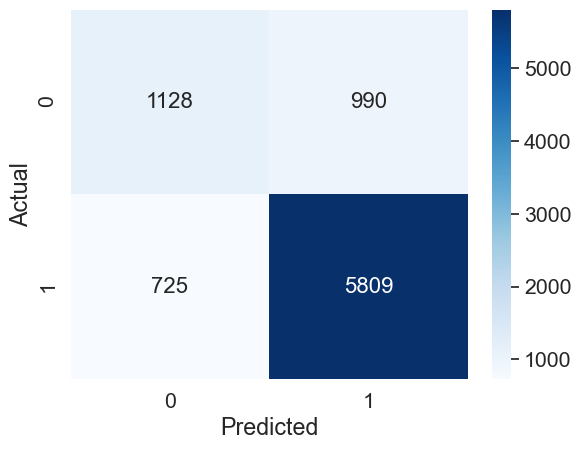

***** Category: request ***** 
***** Testing data *****
F1 Score 0.6416878865041834




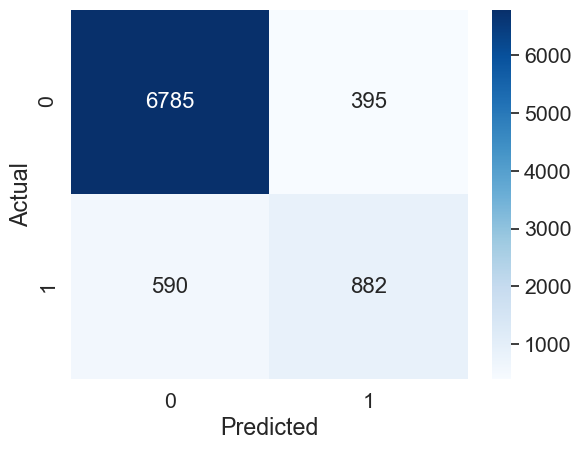

***** Category: offer ***** 
***** Testing data *****
F1 Score 0.044444444444444446




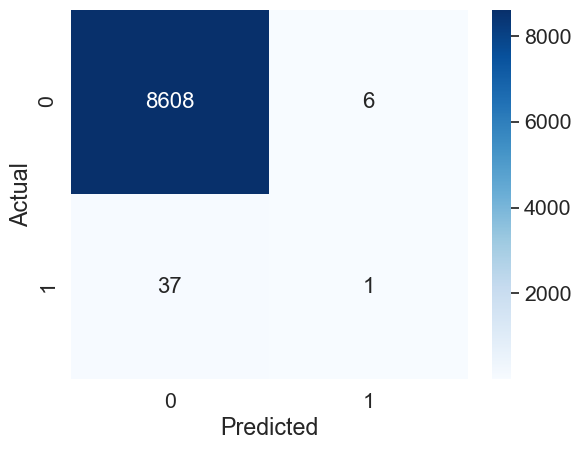

***** Category: aid_related ***** 
***** Testing data *****
F1 Score 0.6849315068493151




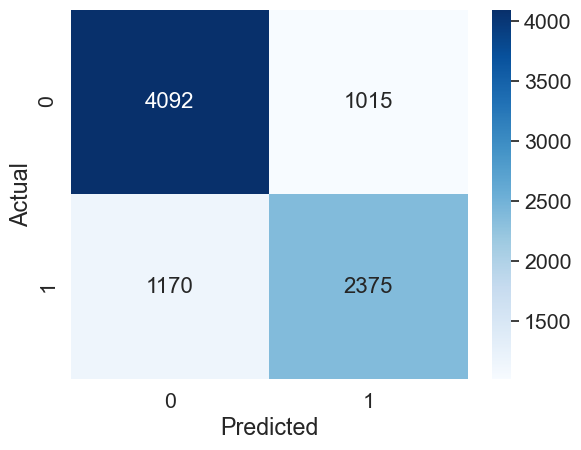

***** Category: medical_help ***** 
***** Testing data *****
F1 Score 0.36605657237936773




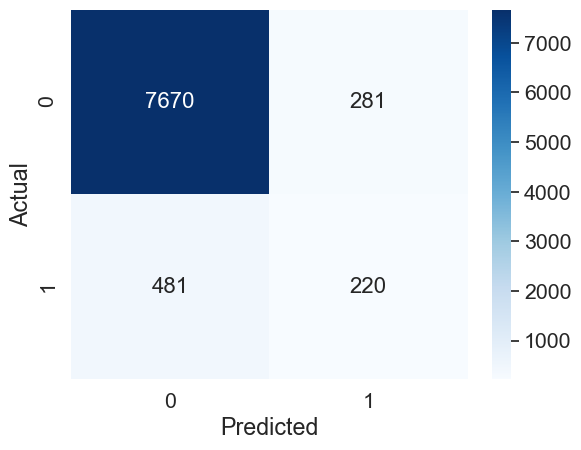

***** Category: medical_products ***** 
***** Testing data *****
F1 Score 0.34594594594594597




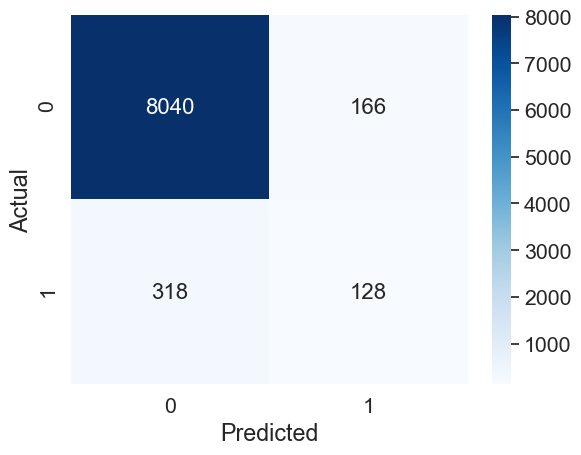

***** Category: search_and_rescue ***** 
***** Testing data *****
F1 Score 0.22093023255813954




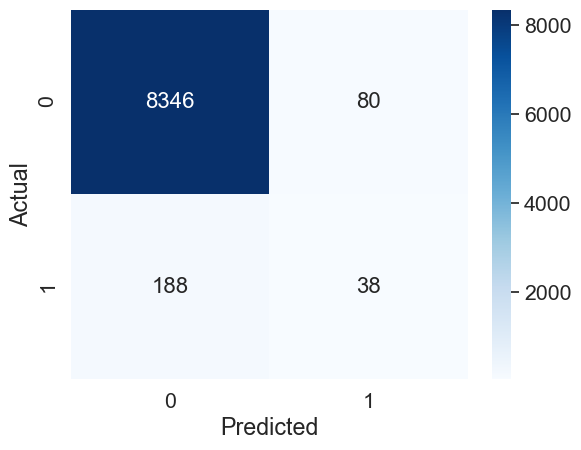

***** Category: security ***** 
***** Testing data *****
F1 Score 0.054298642533936646




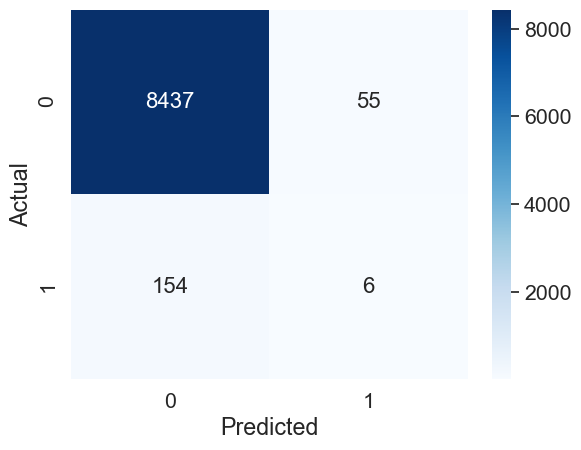

***** Category: military ***** 
***** Testing data *****
F1 Score 0.3799126637554585




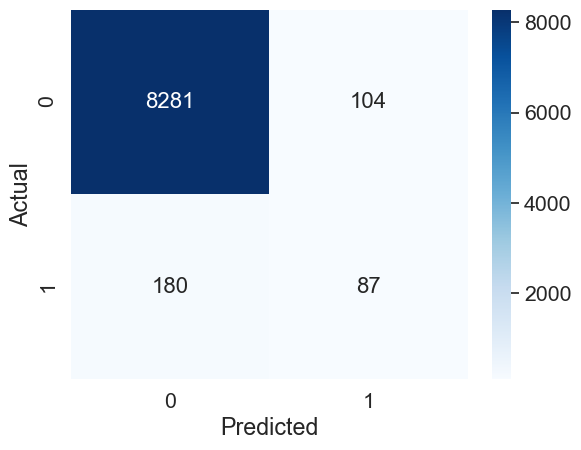

***** Category: child_alone ***** 
***** Testing data *****
F1 Score 0.0


***** Category: water ***** 
***** Testing data *****
F1 Score 0.6452866861030127




/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


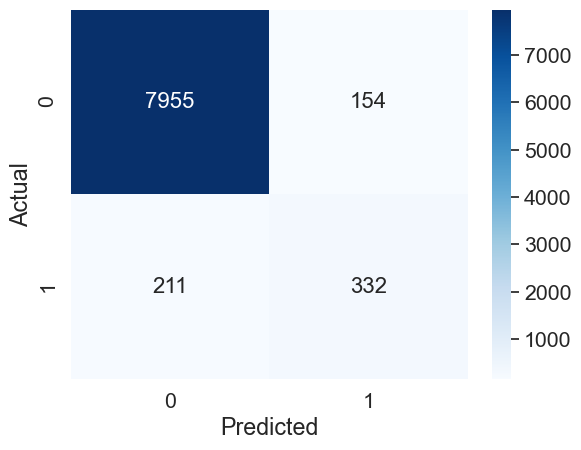

***** Category: food ***** 
***** Testing data *****
F1 Score 0.7295258620689656




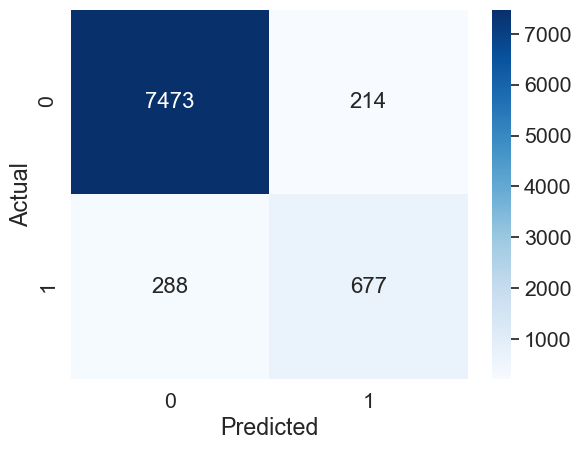

***** Category: shelter ***** 
***** Testing data *****
F1 Score 0.6081460674157304




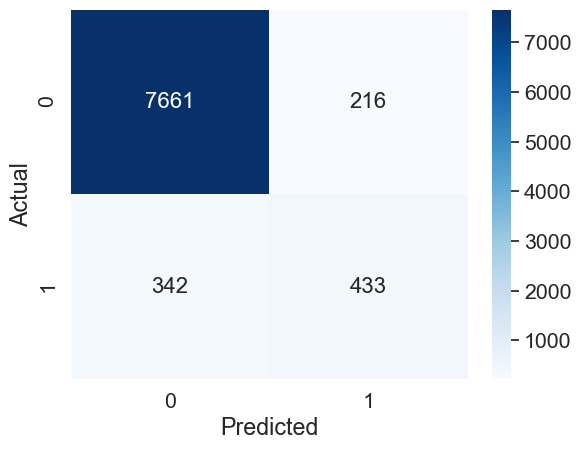

***** Category: clothing ***** 
***** Testing data *****
F1 Score 0.48113207547169806




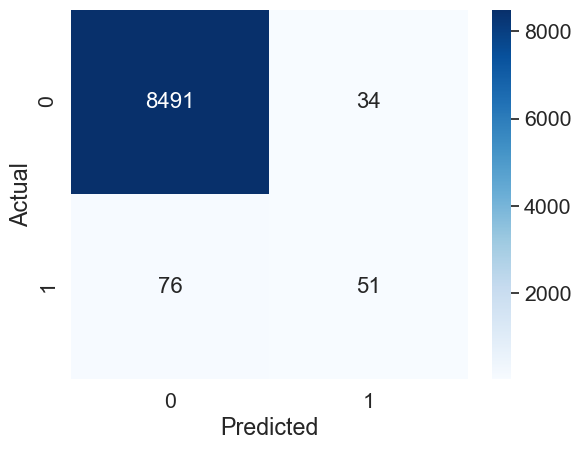

***** Category: money ***** 
***** Testing data *****
F1 Score 0.3548387096774194




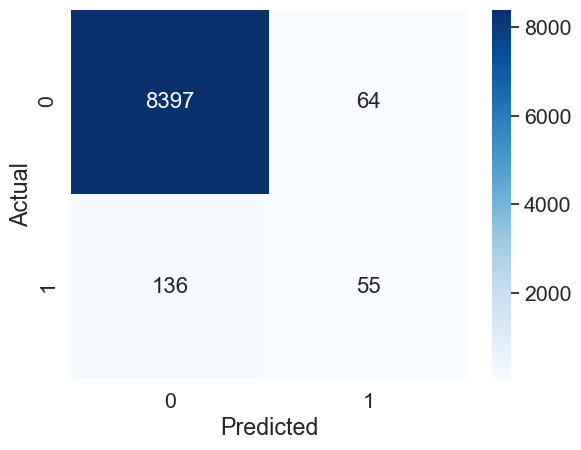

***** Category: missing_people ***** 
***** Testing data *****
F1 Score 0.21126760563380279




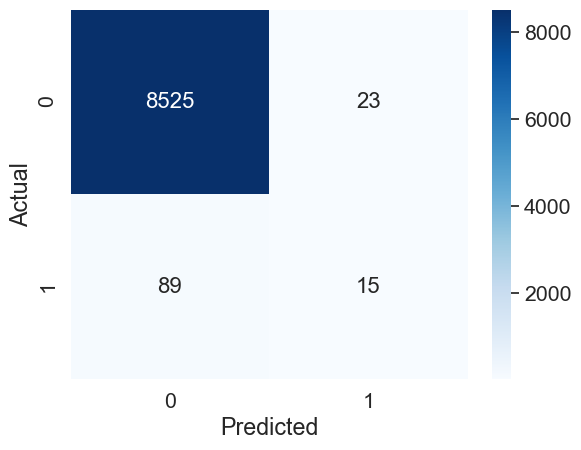

***** Category: refugees ***** 
***** Testing data *****
F1 Score 0.3274336283185841




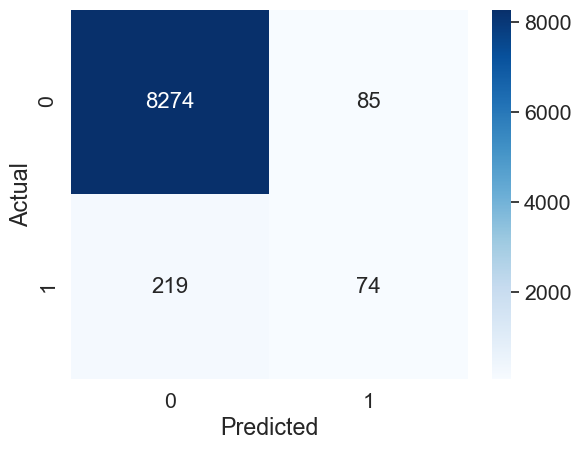

***** Category: death ***** 
***** Testing data *****
F1 Score 0.49189985272459513




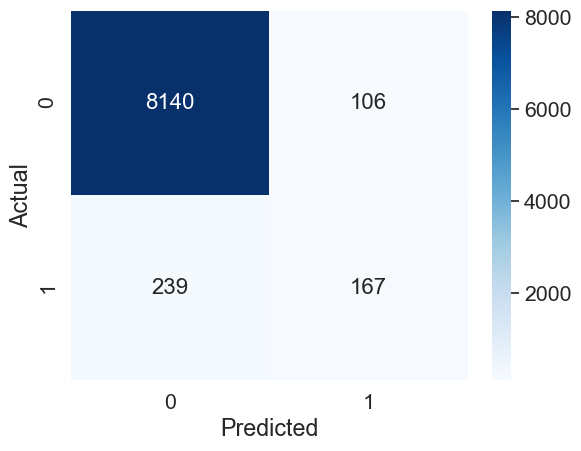

***** Category: other_aid ***** 
***** Testing data *****
F1 Score 0.29442691903259727




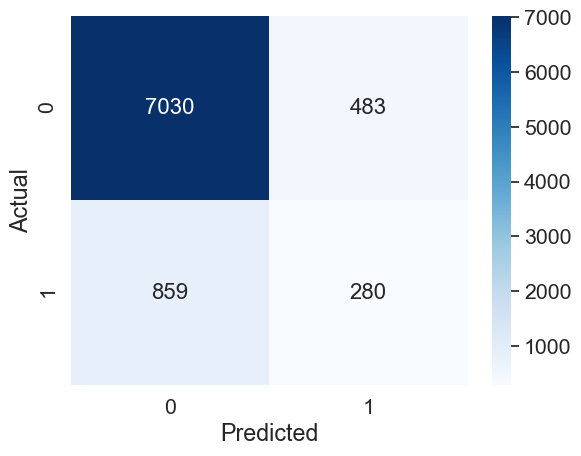

***** Category: infrastructure_related ***** 
***** Testing data *****
F1 Score 0.15419501133786848




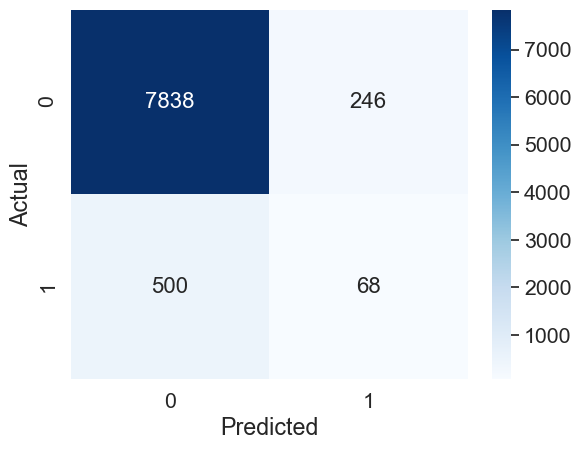

***** Category: transport ***** 
***** Testing data *****
F1 Score 0.2569659442724458




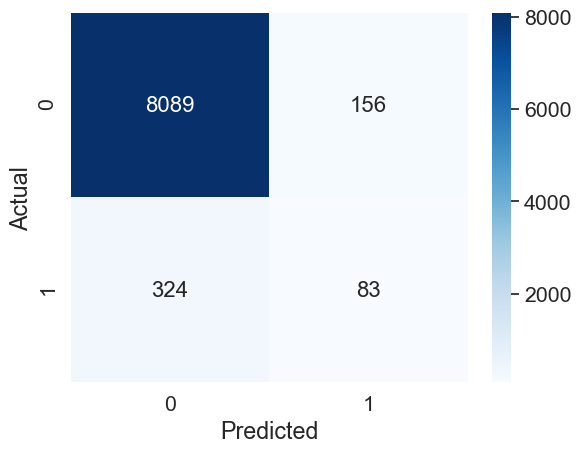

***** Category: buildings ***** 
***** Testing data *****
F1 Score 0.428380187416332




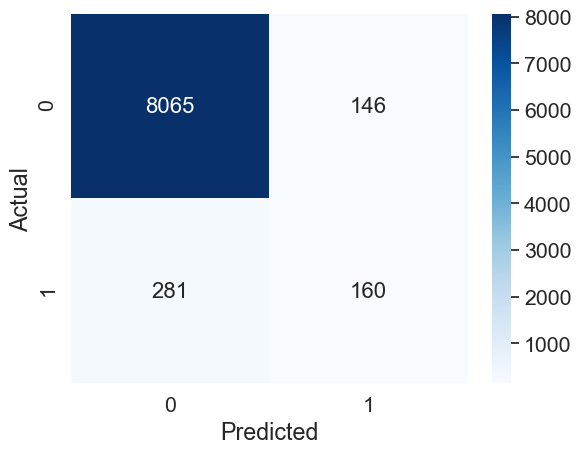

***** Category: electricity ***** 
***** Testing data *****
F1 Score 0.3333333333333333




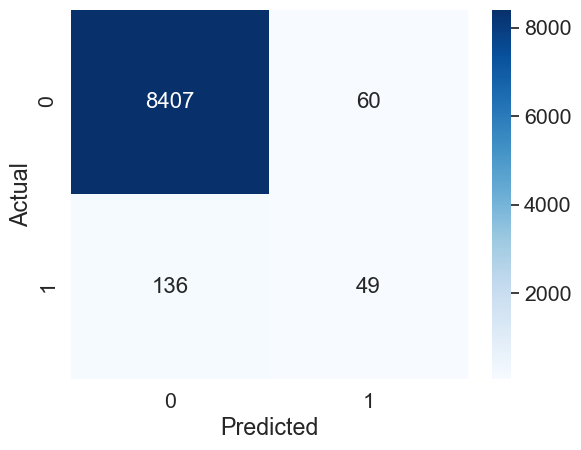

***** Category: tools ***** 
***** Testing data *****
F1 Score 0.0




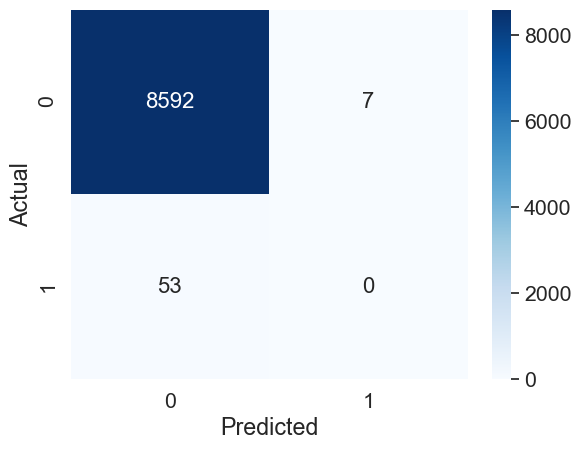

***** Category: hospitals ***** 
***** Testing data *****
F1 Score 0.13740458015267176




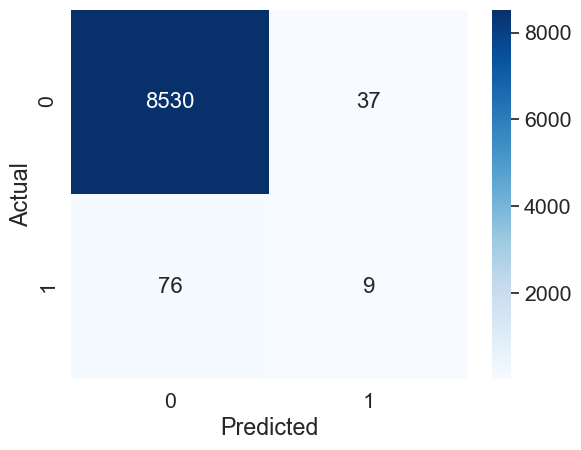

***** Category: shops ***** 
***** Testing data *****
F1 Score 0.0




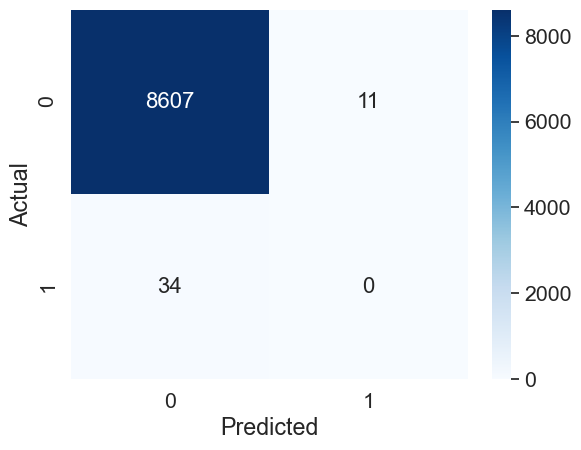

***** Category: aid_centers ***** 
***** Testing data *****
F1 Score 0.08163265306122448




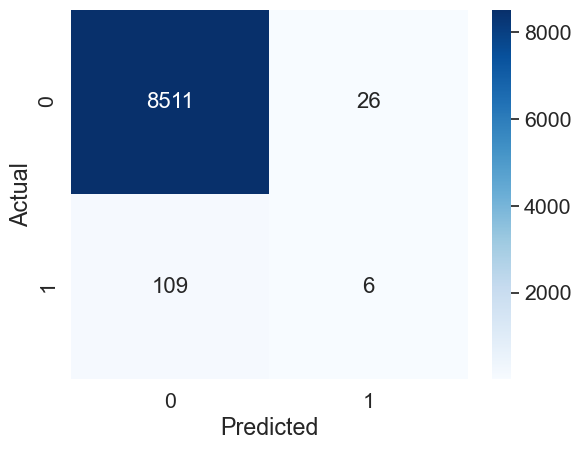

***** Category: other_infrastructure ***** 
***** Testing data *****
F1 Score 0.12000000000000001




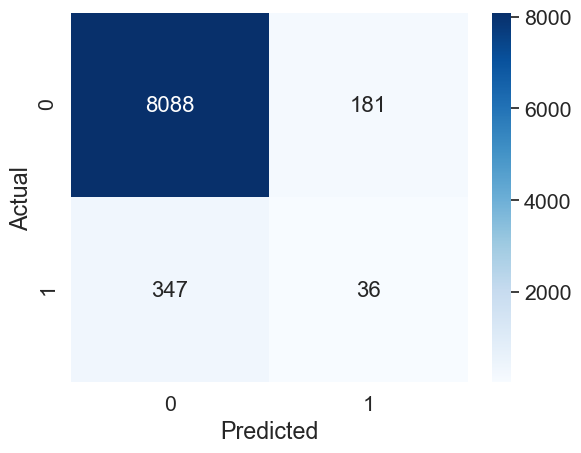

***** Category: weather_related ***** 
***** Testing data *****
F1 Score 0.729208250166334




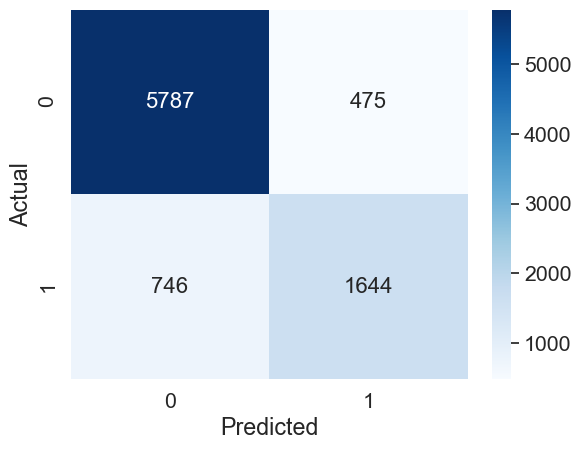

***** Category: floods ***** 
***** Testing data *****
F1 Score 0.6110210696920584




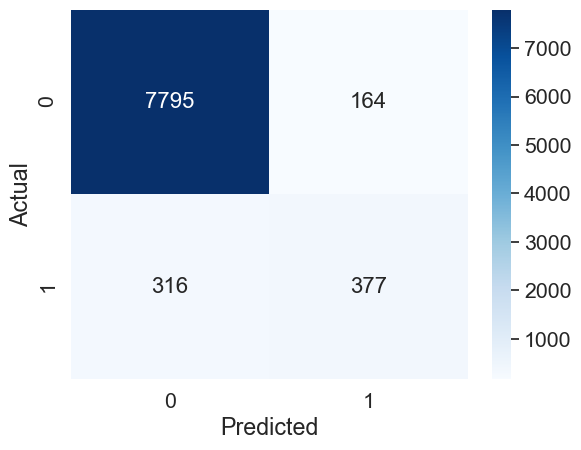

***** Category: storm ***** 
***** Testing data *****
F1 Score 0.631233595800525




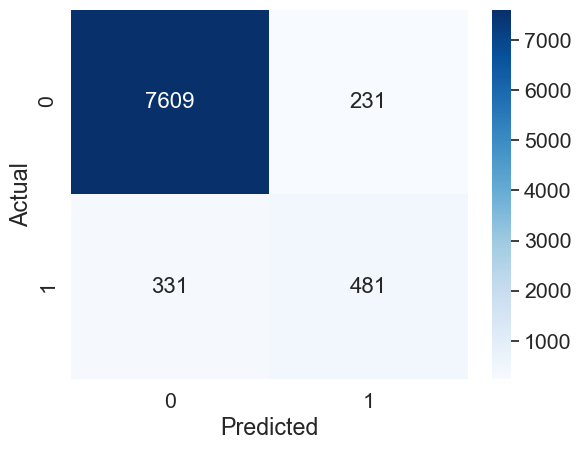

***** Category: fire ***** 
***** Testing data *****
F1 Score 0.31111111111111117




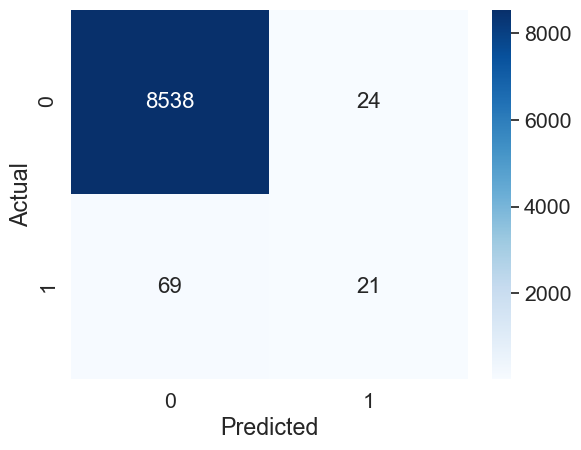

***** Category: earthquake ***** 
***** Testing data *****
F1 Score 0.7760591795561533




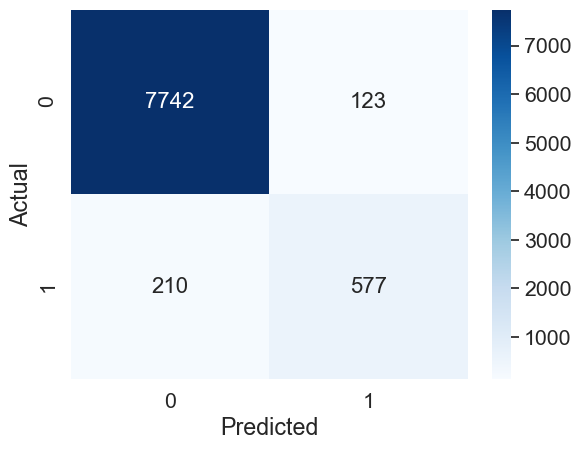

***** Category: cold ***** 
***** Testing data *****
F1 Score 0.49333333333333346




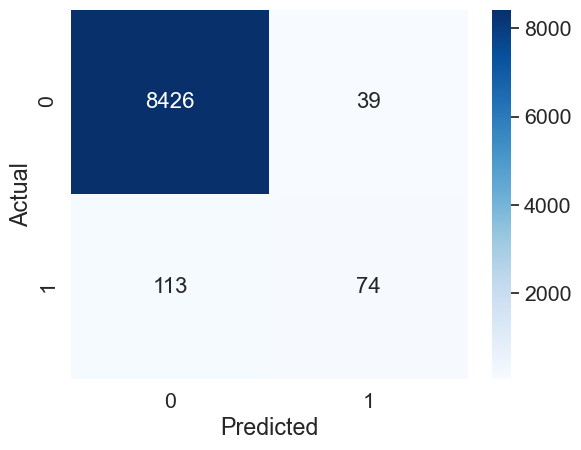

***** Category: other_weather ***** 
***** Testing data *****
F1 Score 0.23013698630136986




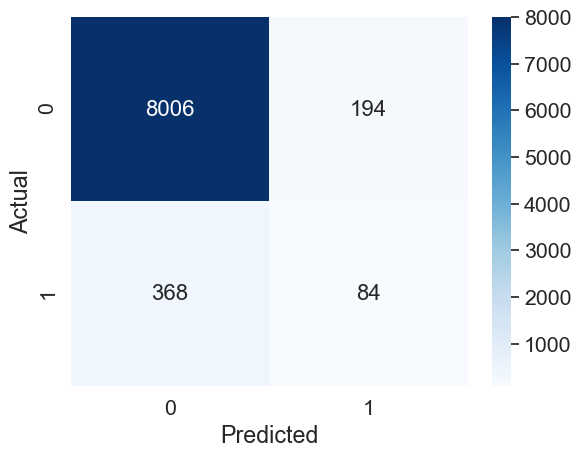

***** Category: direct_report ***** 
***** Testing data *****
F1 Score 0.5689376816273812




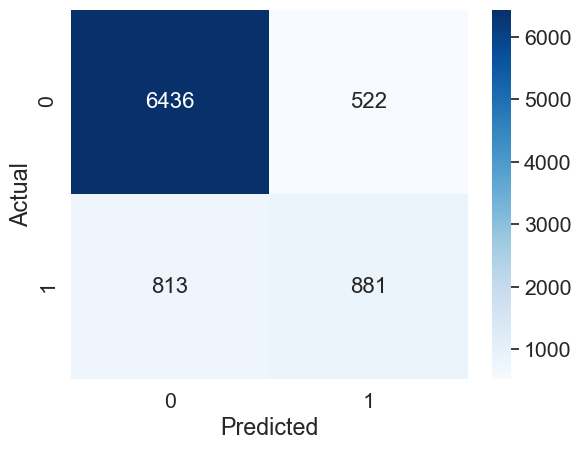

In [18]:
f1_list_improved, recall_list_improved = test_pipeline(y_pred, y_test, categories)


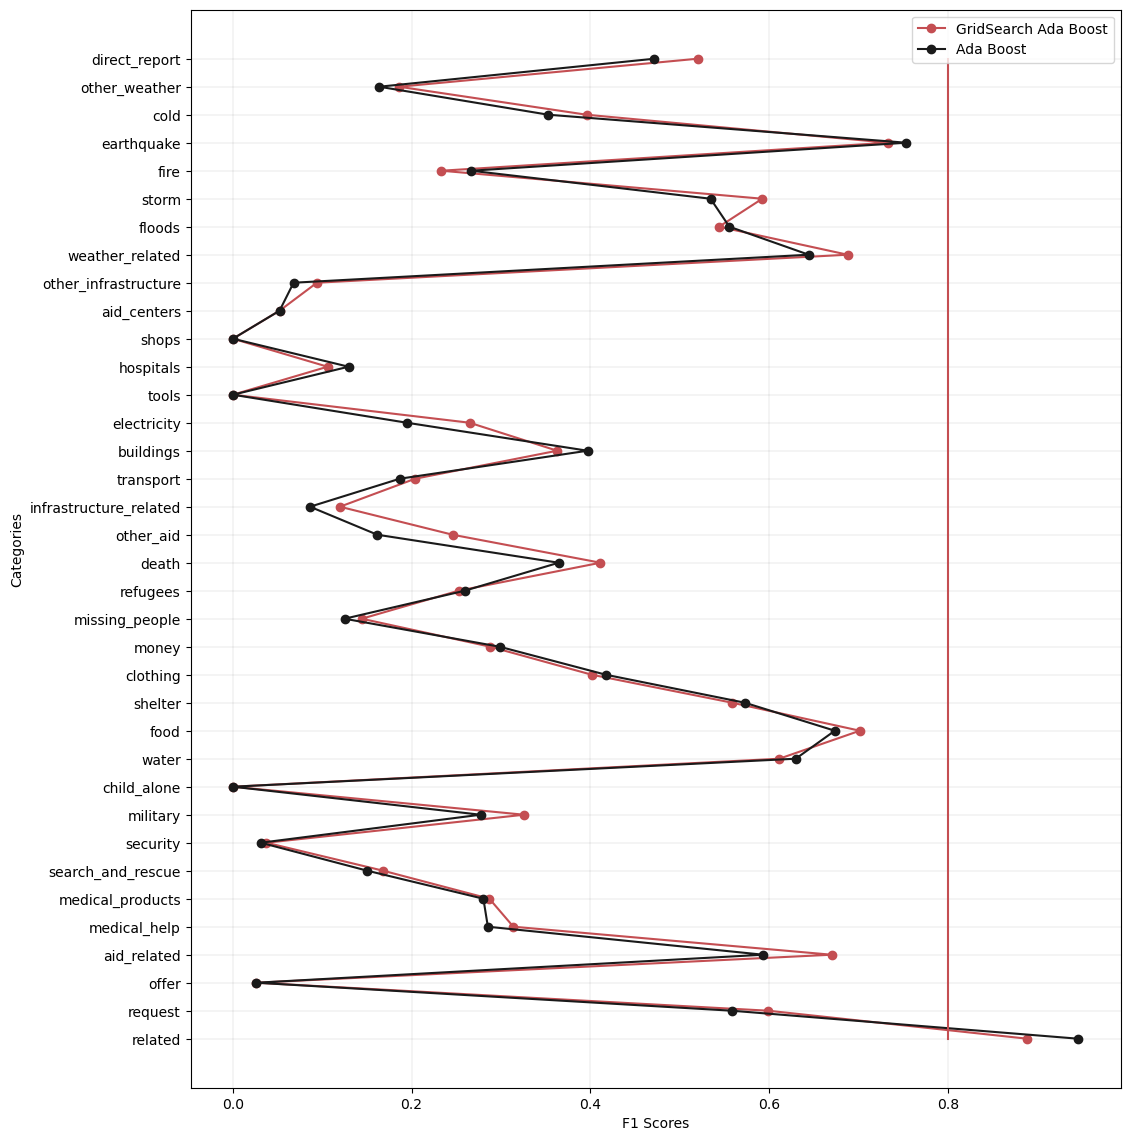

In [19]:
plt.rcParams.update(plt.rcParamsDefault)

plt.figure(figsize=(12, 14)) 


plt.plot(recall_list_improved, categories,'o-r', label = 'GridSearch Ada Boost')
plt.plot(recall_list_ada, categories, 'o-k', label = 'Ada Boost')


plt.plot([0.8] * len(categories), categories, '-r')
plt.xlabel('F1 Scores')
plt.ylabel('Categories')
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.legend(loc="upper right")

plt.show()

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [20]:
from sklearn.feature_selection import VarianceThreshold


In [21]:
# tfidf = TfidfVectorizer(min_df=2,max_df=0.5, ngram_range=(1,3))

# tfidf = TfidfVectorizer(tokenizer=tokenize, sublinear_tf=True,
#                                             strip_accents='unicode',
#                                             analyzer='word',
#                                             token_pattern=r'\w{1,}',
#                                             ngram_range=(1,4),
#                                             max_features = 10000)

In [22]:
# tfidf = TfidfVectorizer(min_df=2,max_df=0.5, ngram_range=(1,3))

tfidf = TfidfVectorizer(tokenizer=tokenize,sublinear_tf=True,
                                        stop_words = 'english',
                                        strip_accents='unicode',
                                        analyzer='word',
                                        token_pattern=r'\w{1,}',
                                        ngram_range=(1,4),
                                        dtype=np.float32,
                                        max_features = 10000)
features = tfidf.fit_transform(df.message)
df_message = pd.DataFrame(
    features.todense(),
    columns=tfidf.get_feature_names()
)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'el', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'le', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'plea', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'u', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [23]:
X_train, X_test, y_train, y_test = train_test_split(df_message, Y, test_size = 0.33, random_state = 42)

In [24]:
constant_filter = VarianceThreshold(threshold = 0.0002)
constant_filter.fit(X_train)
feature_list = X_train[X_train.columns[constant_filter.get_support(indices=True)]]
print('Number of selected features: ' ,len(list(feature_list)),'\n')
print('List of selected features: \n' ,list(feature_list))

Number of selected features:  1038 

List of selected features: 
 ['!', '! !', '! ! !', '#', '# hurricanesandi', '# sandi', '$', '%', '&', "'", "' r", "' v", "''", "'d", "'d like", "'d like know", "'ll", "'m", "'s", '(', ')', ') ,', ') .', '*', '* *', ',', ", ''", ", 'm", ', ,', ', .', ', ?', ', accord', ', becaus', ', caus', ', did', ', food', ', food ,', ', ha', ', help', ', hous', ', includ', ', like', ', mani', ", n't", ', need', ', peopl', ', plea', ', plea help', ', said', ', said .', ', thank', ', wa', ', want', ', water', ', water ,', '-', '--', '.', '. #', ". ''", ". 'm", '. .', '. ..', '. ?', '. help', '. http', '. like', '. live', ". n't", '. need', '. plea', '. plea help', '. thank', '. thank .', '..', '.. .', '/', '1', '10', '100', '12', '14', '15', '18', '2', '20', '200', '2010', '3', '30', '4', '4636', '4636 .', '5', '50', '6', '7', '8', ':', ': messag', ';', '?', '? )', '? ?', '? thank', '@', '``', 'abl', 'access', 'accord', 'account', 'act', 'action', 'activ', 'addit',

In [25]:
X_train_filter = constant_filter.transform(X_train)
X_test_filter = constant_filter.transform(X_test)
X_train_filter.shape, X_test_filter.shape, X_train.shape

((17564, 1038), (8652, 1038), (17564, 10000))

In [26]:
X_train_filter = pd.DataFrame(X_train_filter)
X_test_filter = pd.DataFrame(X_test_filter)

In [42]:
def get_correlation(data, threshold):
    corr_col = set()
    cormat = data.corr()
    for i in range(len(cormat.columns)):
        for j in range(i):
            if abs(cormat.iloc[i,j]) > threshold:
                colname = cormat.columns[i]
                corr_col.add(colname)
    return corr_col
corr_features = get_correlation(X_train_filter, 0.90)

In [43]:
X_train_uncorr = X_train_filter.drop(labels= corr_features, axis = 1)
X_test_uncorr = X_test_filter.drop(labels= corr_features, axis = 1)
X_train_uncorr = pd.DataFrame(X_train_uncorr)
X_test_uncorr = pd.DataFrame(X_test_uncorr)
X_train_uncorr.shape, X_test_uncorr.shape

((17564, 1028), (8652, 1028))

In [44]:
pipeline_ada_tf = Pipeline([('classifier',
                     MultiOutputClassifier(estimator=AdaBoostClassifier(n_estimators=100,
                                                                    random_state=42)))])

***** Category: related ***** 
***** Testing data *****
F1 Score 0.870708546384222




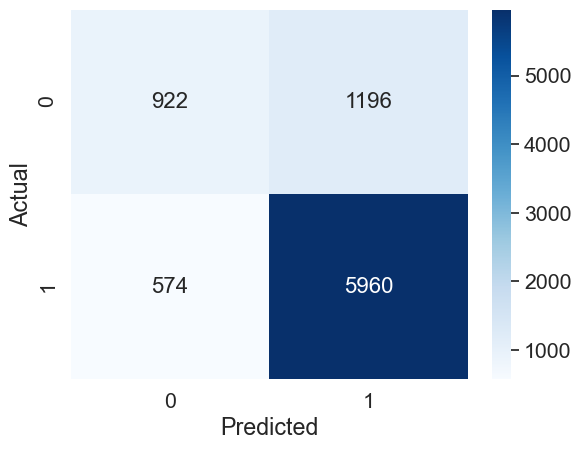

***** Category: request ***** 
***** Testing data *****
F1 Score 0.6296444266879744




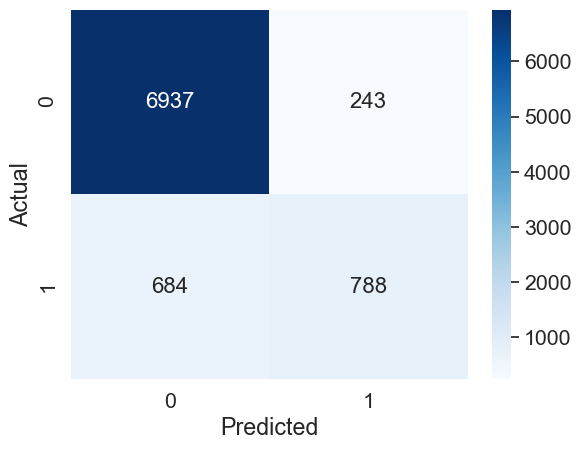

***** Category: offer ***** 
***** Testing data *****
F1 Score 0.0




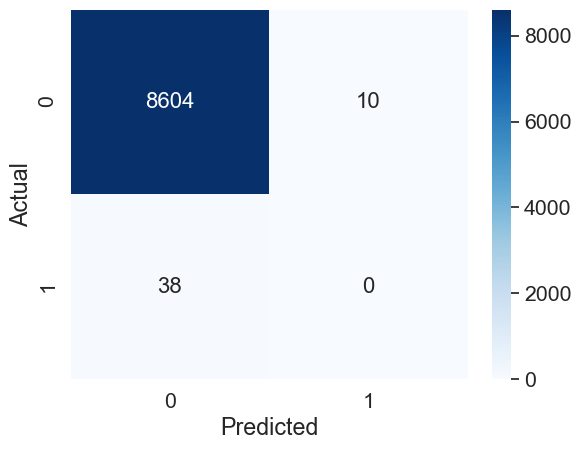

***** Category: aid_related ***** 
***** Testing data *****
F1 Score 0.6835752482811307




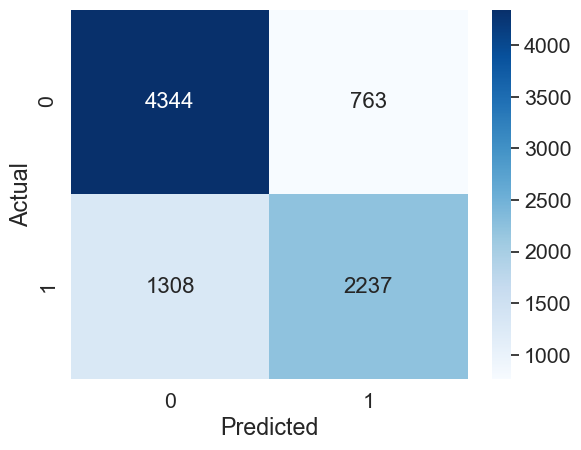

***** Category: medical_help ***** 
***** Testing data *****
F1 Score 0.35651322233104804




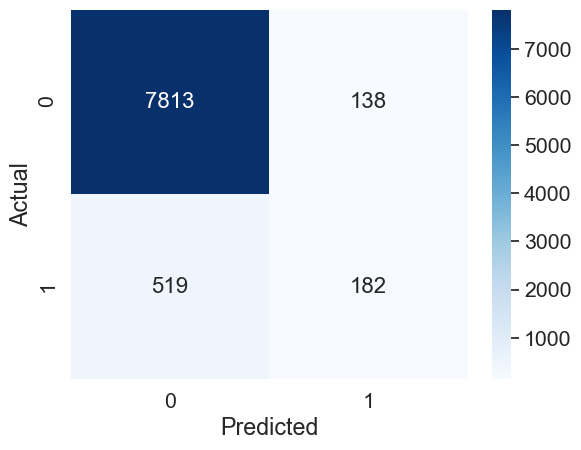

***** Category: medical_products ***** 
***** Testing data *****
F1 Score 0.35387045813586093




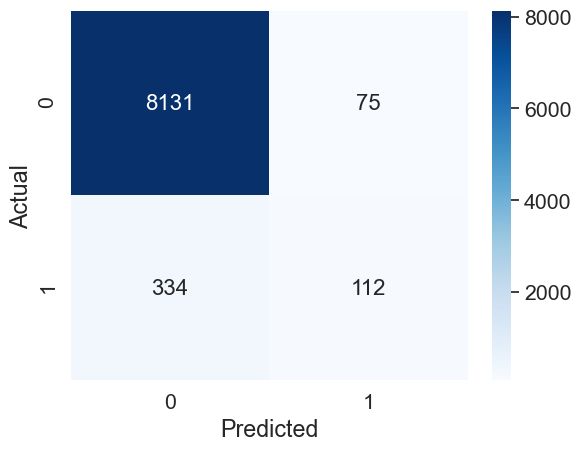

***** Category: search_and_rescue ***** 
***** Testing data *****
F1 Score 0.23076923076923078




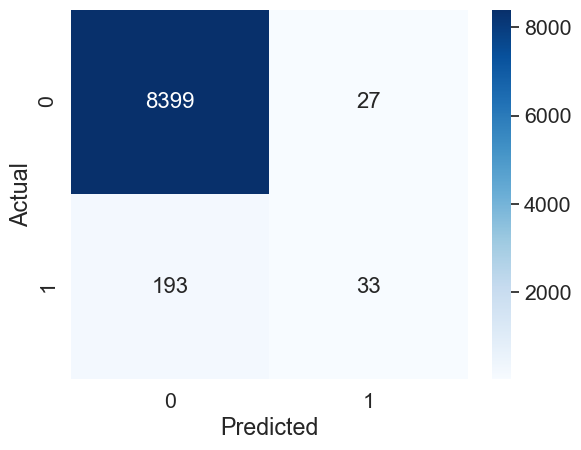

***** Category: security ***** 
***** Testing data *****
F1 Score 0.04278074866310161




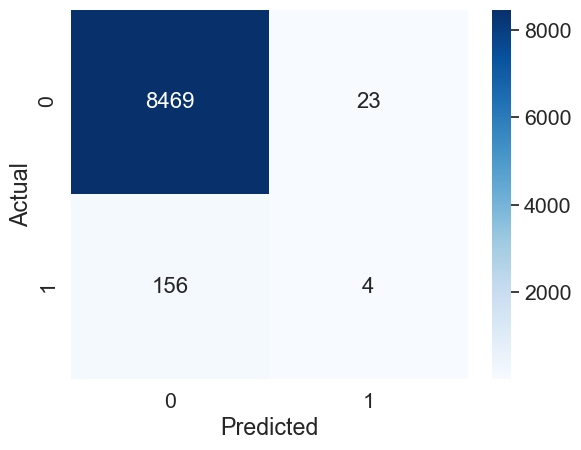

***** Category: military ***** 
***** Testing data *****
F1 Score 0.30334190231362473




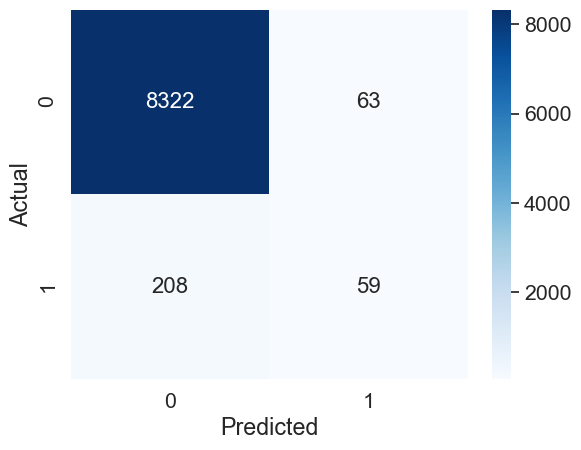

***** Category: child_alone ***** 
***** Testing data *****
F1 Score 0.0


***** Category: water ***** 
***** Testing data *****
F1 Score 0.6613861386138613




/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


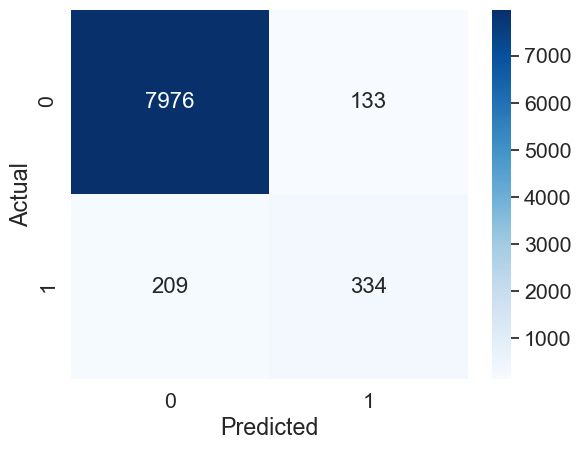

***** Category: food ***** 
***** Testing data *****
F1 Score 0.7340182648401827




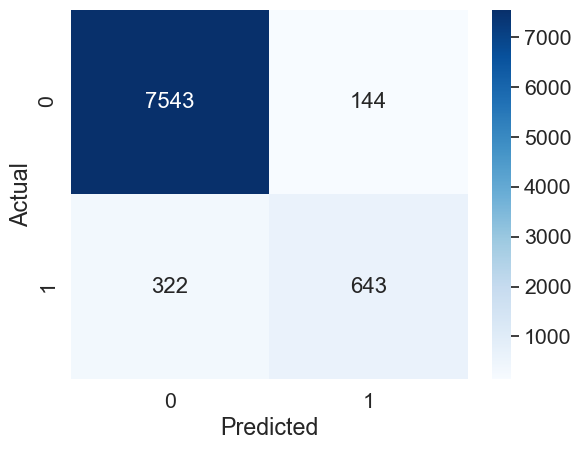

***** Category: shelter ***** 
***** Testing data *****
F1 Score 0.6267978803936411




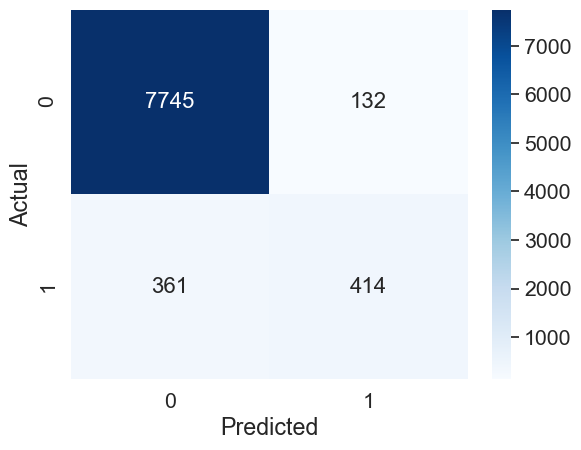

***** Category: clothing ***** 
***** Testing data *****
F1 Score 0.41884816753926696




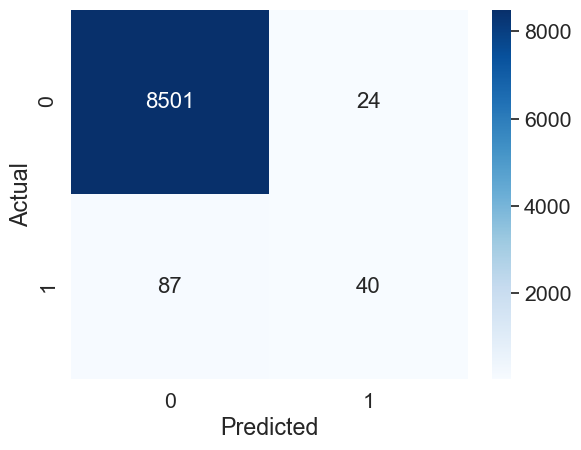

***** Category: money ***** 
***** Testing data *****
F1 Score 0.3642384105960265




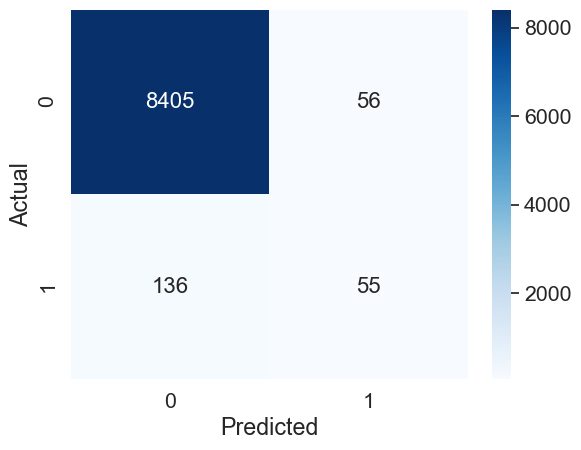

***** Category: missing_people ***** 
***** Testing data *****
F1 Score 0.1311475409836066




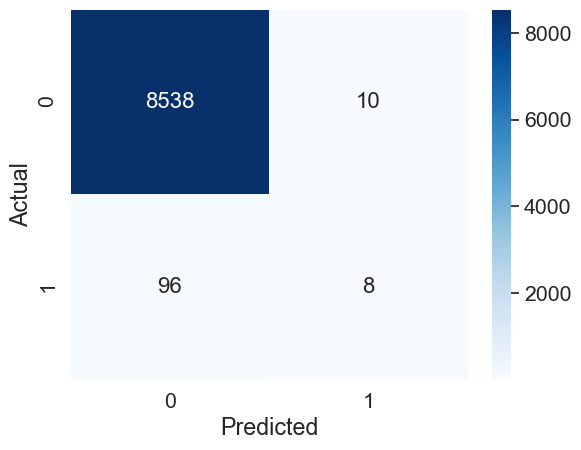

***** Category: refugees ***** 
***** Testing data *****
F1 Score 0.30071599045346065




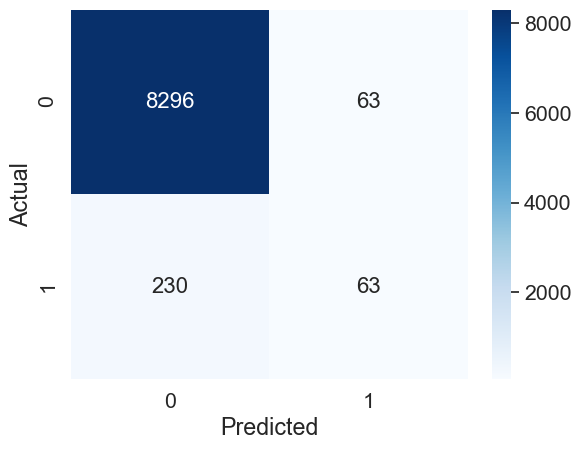

***** Category: death ***** 
***** Testing data *****
F1 Score 0.49687499999999996




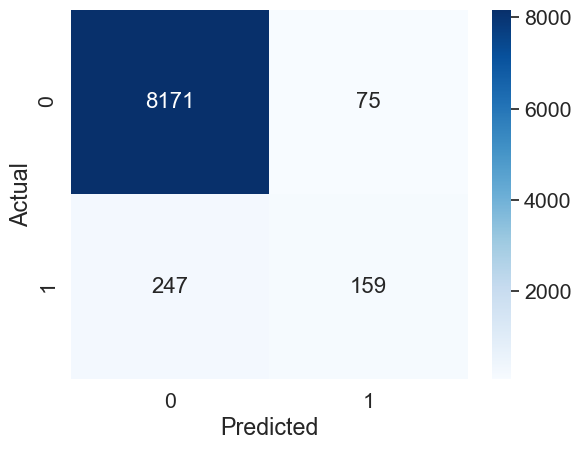

***** Category: other_aid ***** 
***** Testing data *****
F1 Score 0.23624161073825503




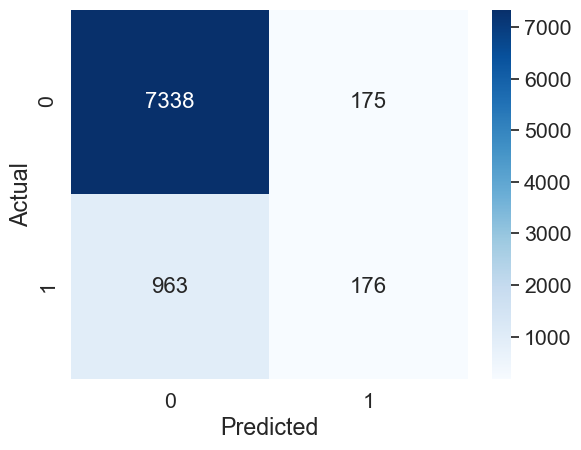

***** Category: infrastructure_related ***** 
***** Testing data *****
F1 Score 0.17573221757322177




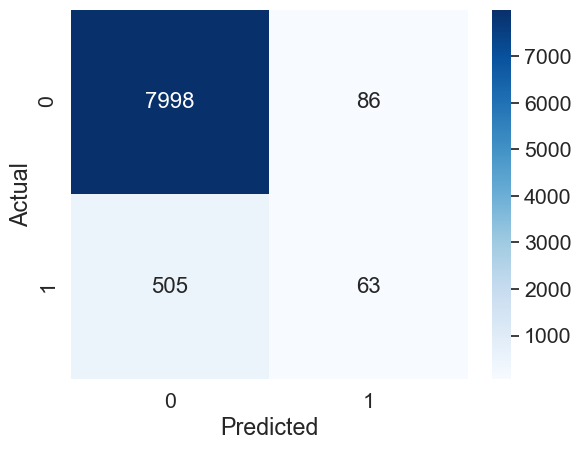

***** Category: transport ***** 
***** Testing data *****
F1 Score 0.32282003710575136




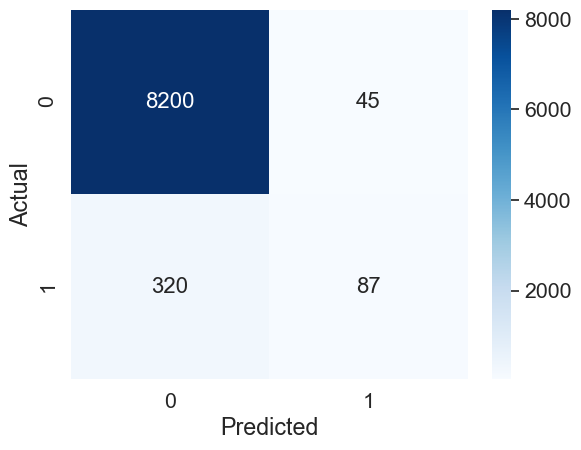

***** Category: buildings ***** 
***** Testing data *****
F1 Score 0.4832605531295487




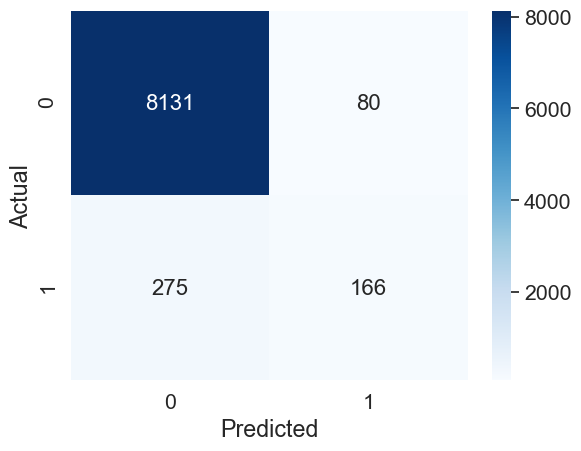

***** Category: electricity ***** 
***** Testing data *****
F1 Score 0.25984251968503935




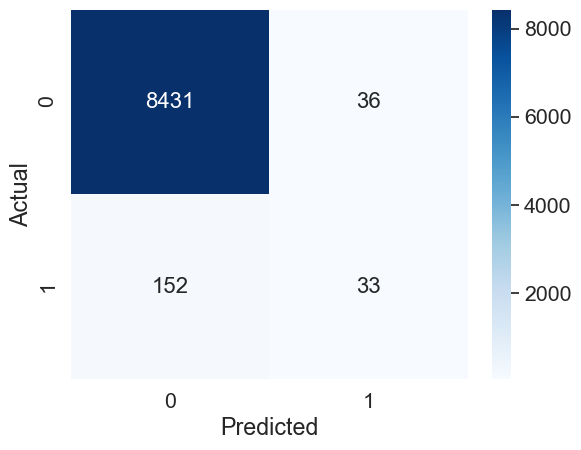

***** Category: tools ***** 
***** Testing data *****
F1 Score 0.0




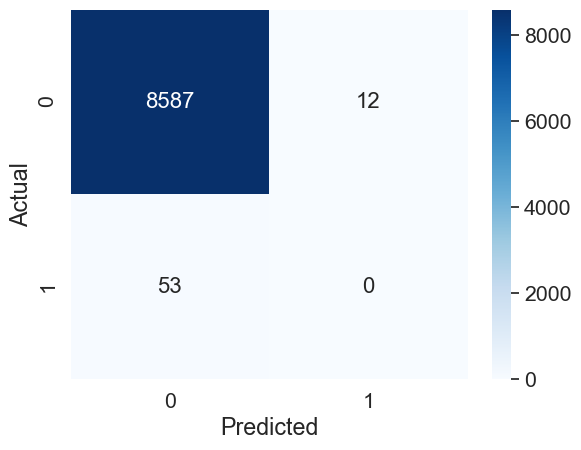

***** Category: hospitals ***** 
***** Testing data *****
F1 Score 0.16666666666666669




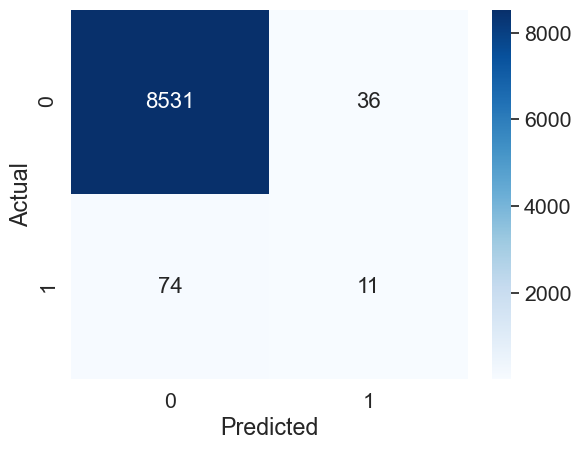

***** Category: shops ***** 
***** Testing data *****
F1 Score 0.0




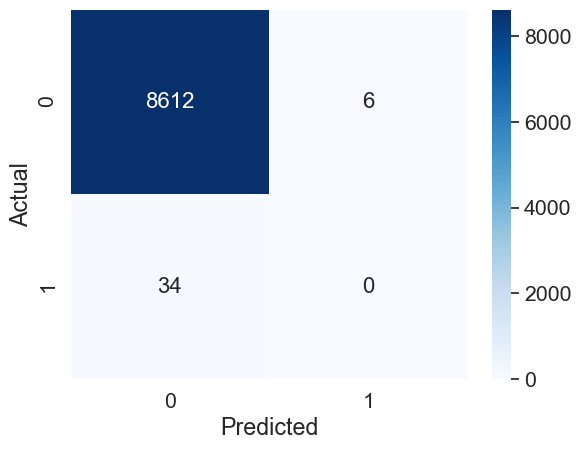

***** Category: aid_centers ***** 
***** Testing data *****
F1 Score 0.07042253521126761




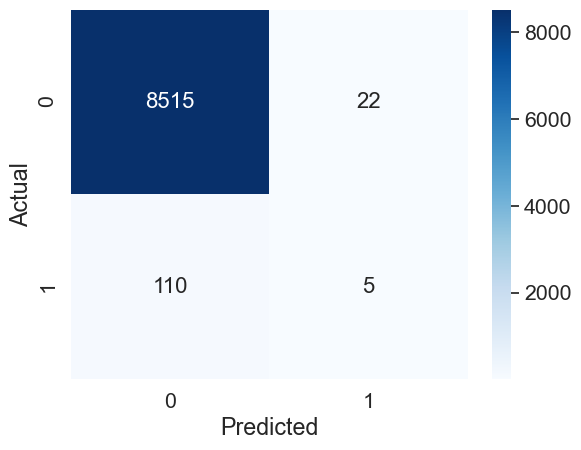

***** Category: other_infrastructure ***** 
***** Testing data *****
F1 Score 0.10822510822510825




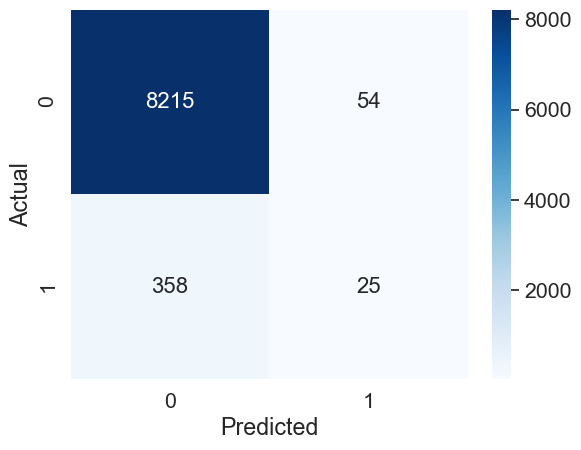

***** Category: weather_related ***** 
***** Testing data *****
F1 Score 0.7263355201499532




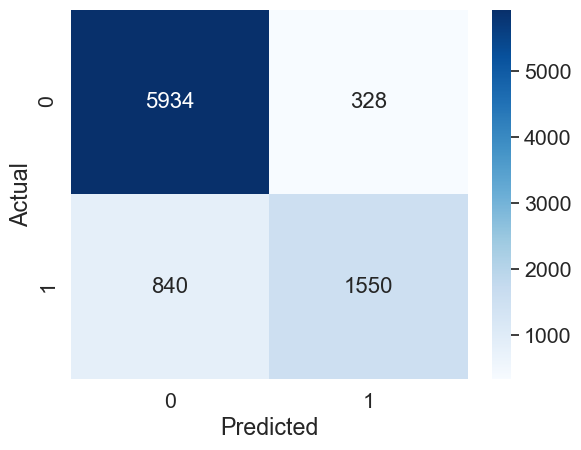

***** Category: floods ***** 
***** Testing data *****
F1 Score 0.6138790035587188




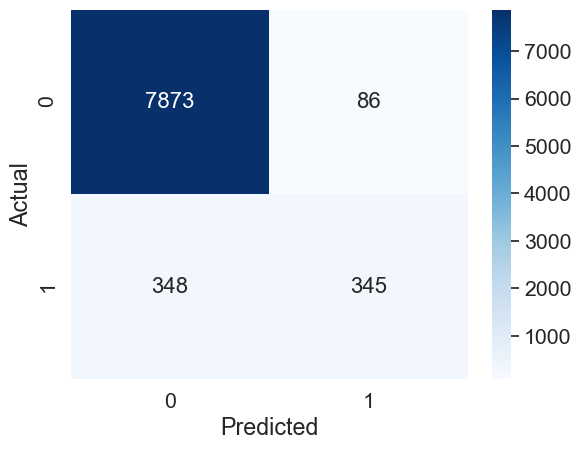

***** Category: storm ***** 
***** Testing data *****
F1 Score 0.6019830028328612




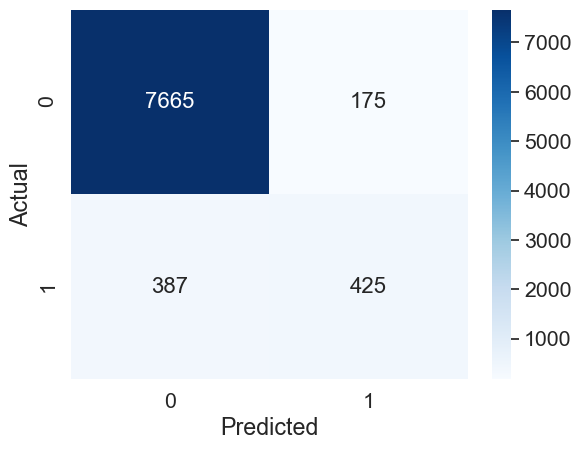

***** Category: fire ***** 
***** Testing data *****
F1 Score 0.056074766355140186




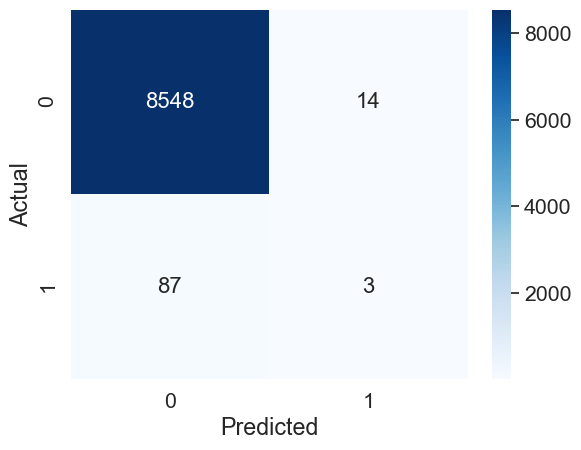

***** Category: earthquake ***** 
***** Testing data *****
F1 Score 0.7787857641311933




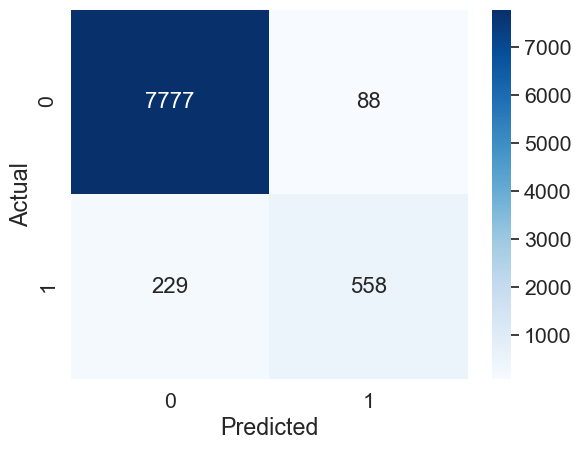

***** Category: cold ***** 
***** Testing data *****
F1 Score 0.41258741258741255




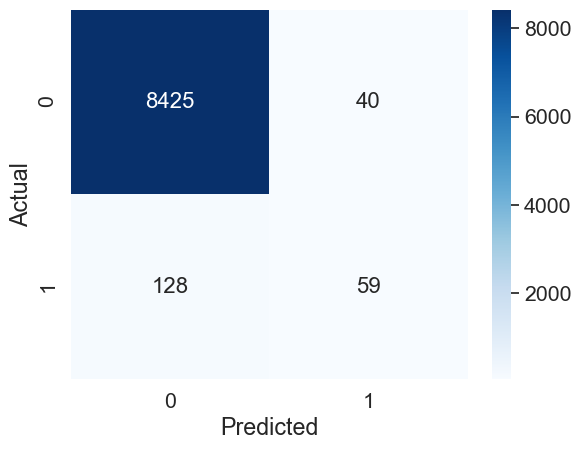

***** Category: other_weather ***** 
***** Testing data *****
F1 Score 0.21122112211221122




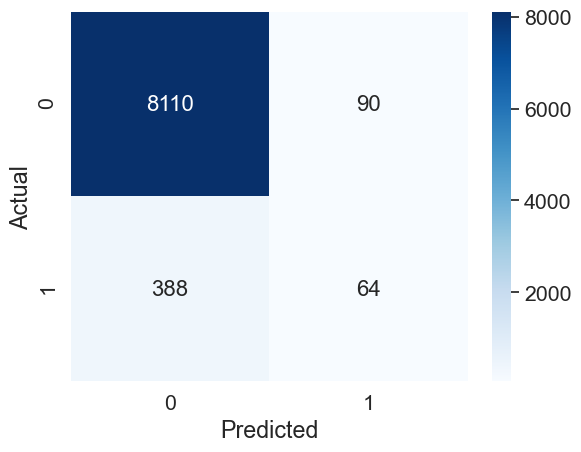

***** Category: direct_report ***** 
***** Testing data *****
F1 Score 0.5125515174222555




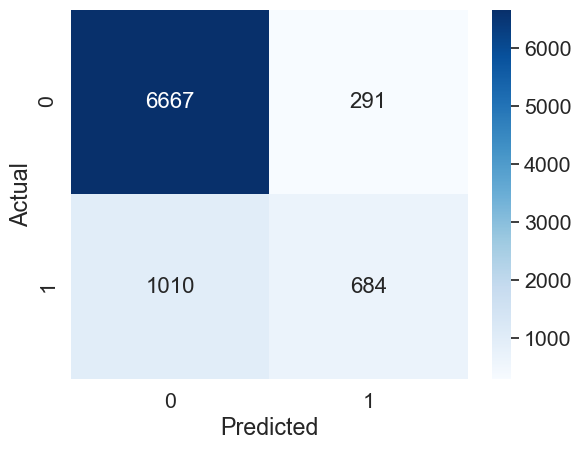

In [45]:
pipeline_ada_tf.fit(X_train_uncorr, y_train)
y_pred = pipeline_ada_tf.predict(X_test_uncorr)
f1_list_improved_2, recall_list_improved_2 = test_pipeline(y_pred, y_test, categories)

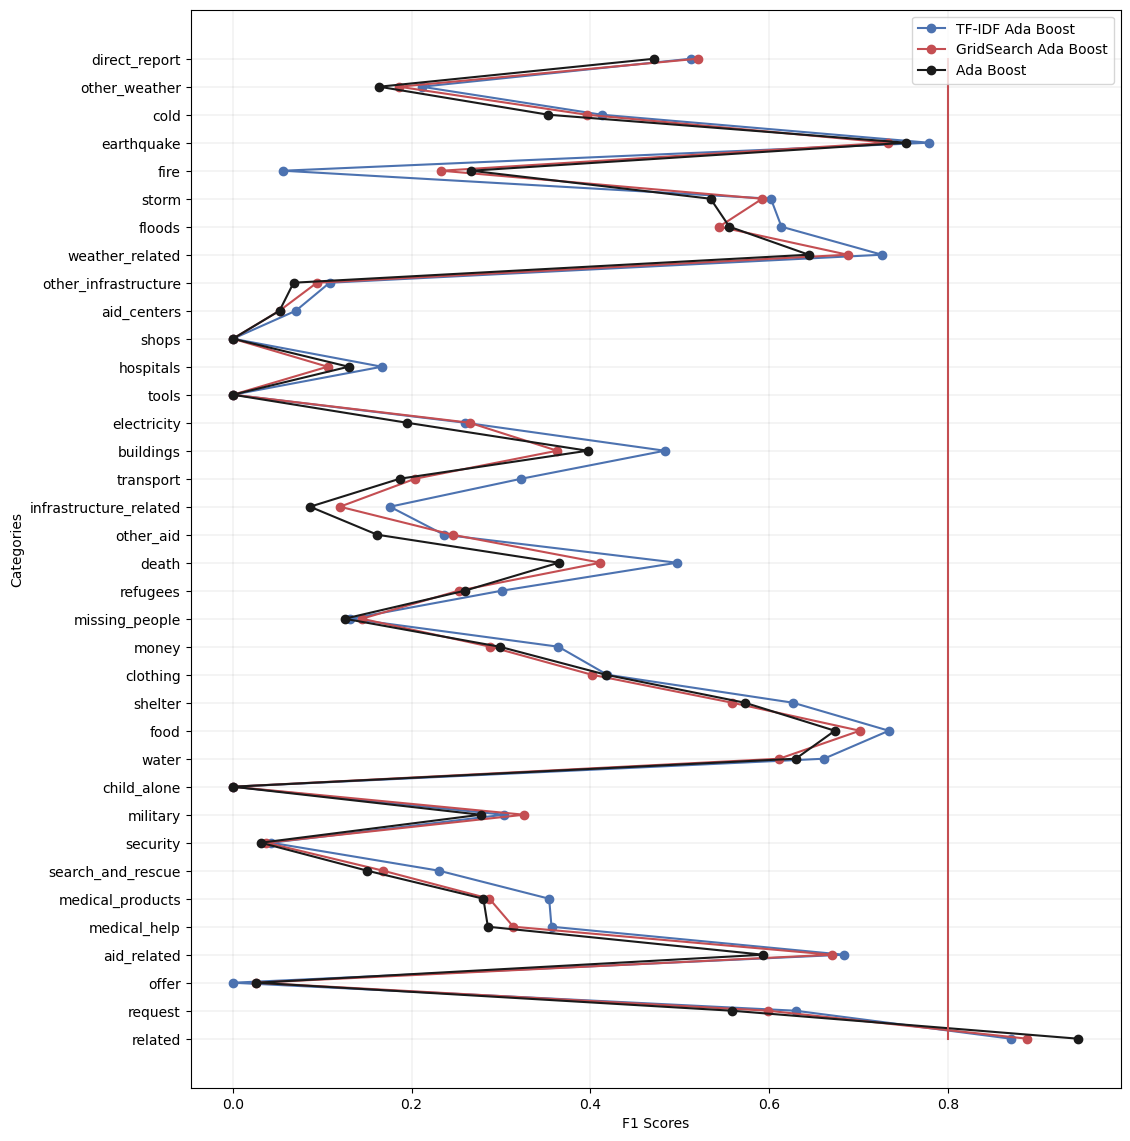

In [47]:
plt.rcParams.update(plt.rcParamsDefault)

plt.figure(figsize=(12, 14)) 

plt.plot(f1_list_improved_2, categories,'o-b', label = 'TF-IDF Ada Boost')

plt.plot(recall_list_improved, categories,'o-r', label = 'GridSearch Ada Boost')
plt.plot(recall_list_ada, categories, 'o-k', label = 'Ada Boost')


plt.plot([0.8] * len(categories), categories, '-r')
plt.xlabel('F1 Scores')
plt.ylabel('Categories')
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.legend(loc="upper right")

plt.show()

### 9. Export your model as a pickle file

In [49]:
with open('model.pkl', 'wb') as f:
    pickle.dump(pipeline_ada_tf, f)

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.